In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Embedding, Flatten, Dropout,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('final_combined_dataset.csv')

# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]
# df = df.drop(columns=['geocode'])

df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)


df["year_sin"] = np.sin(2 * np.pi * df["year"] / df["year"].max())
df["year_cos"] = np.cos(2 * np.pi * df["year"] / df["year"].max())


# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0,1, -2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[4, 5, 6])
data = data.dropna().reset_index(drop=True)


# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Fit and transform the 'geocode' column
data['geocode'] = label_encoder.fit_transform(data['geocode'])

train_data = data[data['date'].dt.year <= 2020]
test_data = data[data['date'].dt.year >= 2021]

print("Training set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

X_train = train_data.drop(columns=['cases','cases_per_100k','cases_lag-2'])
y_train = train_data[['cases_lag-2']]

X_test = test_data.drop(columns=['cases','cases_per_100k','cases_lag-2'])
y_test = test_data[['cases_lag-2']]

data = data.drop(columns=['date','cases_per_100k'])


columns_not_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                    'geocode', 'year_sin', 'year_cos'] 

selected_columns = [
    'cases_lag0', 'cases_lag1',
    'temp_avg_lag4', 'humidity_avg_lag4',
    'precipitation_max_regression_kriging_lag4',
    # 'week_sin', 'month_sin', 'week_cos', 'month_cos',
    # 'year_sin', 'year_cos',
    'geocode'
]


X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

numeric_cols = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                   and col not in columns_not_to_scale]


# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the selected numeric features
X_train[numeric_cols] = feature_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = feature_scaler.transform(X_test[numeric_cols])

# Scale the target variable
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)


# Filter the dataset to keep only these columns
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

Training set shape: (42224, 64)
Test set shape: (9282, 64)


In [8]:
seq_length = 4

def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length].values)  # Select seq_length rows as input
        y.append(target[i + seq_length])  # Select the next row as the target
    return np.array(X), np.array(y)


def create_sequences_geocode_wise(data, target, seq_length):
    X, y = [], []

    # Group by geocode
    for geocode in data['geocode'].unique():
        geocode_data = data[data['geocode'] == geocode]  # Filter rows for this geocode
        geocode_target = target[data['geocode'] == geocode]  # Corresponding target values

        # Create sequences for this geocode
        X_geo, y_geo = create_sequences(geocode_data, geocode_target, seq_length)

        # Append to the lists
        X.append(X_geo)
        y.append(y_geo)

    # Concatenate all geocode-wise sequences
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y


# Create sequences for training (geocode-wise)
X_train, y_train = create_sequences_geocode_wise(X_train, y_train, seq_length)

# Create sequences for testing (geocode-wise)
X_test, y_test = create_sequences_geocode_wise(X_test, y_test, seq_length)

# Print the shapes to verify
print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
print("y_train shape:", y_train.shape)  # (samples,)
print("X_test shape:", X_test.shape)    # (samples, timesteps, features)
print("y_test shape:", y_test.shape)    # (samples,)

# Encode geocode as integers
df['geocode'] = df['geocode'].astype('category').cat.codes  
num_geocodes = df['geocode'].nunique()  # Get number of unique geocodes

# Separate geocode after sequence creation
X_train_lstm = X_train[:, :, :-1]  # Exclude last column (geocode)
X_train_geocode = X_train[:, 0, -1].astype(int)  # Extract geocode as separate categorical input

X_test_lstm = X_test[:, :, :-1]
X_test_geocode = X_test[:, 0, -1].astype(int)

# Print shapes for verification
print("X_train_lstm shape:", X_train_lstm.shape)  # (samples, timesteps, features)
print("X_train_geocode shape:", X_train_geocode.shape)  # (samples,)
print("y_train shape:", y_train.shape)

# Define LSTM model with geocode embeddings
seq_length = X_train_lstm.shape[1]  
num_features = X_train_lstm.shape[2]  


# LSTM Branch
# Minimal LSTM model with essential components only

# LSTM Branch (Time-Series Data)
lstm_input = Input(shape=(seq_length, num_features), name="lstm_input")

# First LSTM Layer with Dropout
lstm_layer = LSTM(64)(lstm_input)

# lstm_layer = LSTM(64, return_sequences=True)(lstm_input)  
# dropout_1 = Dropout(0.3)(lstm_layer)  # Drop 30% of neurons

# # Second LSTM Layer with Dropout
# lstm_layer_2 = LSTM(32)(dropout_1)
# dropout_2 = Dropout(0.3)(lstm_layer_2)  # Drop 30% of neurons

# Geocode Embedding Branch
geocode_input = Input(shape=(1,), name="geocode_input")
geocode_embedding = Embedding(input_dim=num_geocodes + 1, output_dim=7)(geocode_input)
geocode_embedding = Flatten()(geocode_embedding)

# Merge Both Branches
merged = Concatenate()([lstm_layer, geocode_embedding])

# Output Layer
output = Dense(1, activation='linear')(merged)

# Build Model
model = Model(inputs=[lstm_input, geocode_input], outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae']
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

history = model.fit(
    [X_train_lstm, X_train_geocode],
    y_train,
    validation_data=([X_test_lstm, X_test_geocode], y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate
test_loss, test_mae = model.evaluate([X_test_lstm, X_test_geocode], y_test)
print(f"Test MAE: {test_mae:.4f}")


X_train shape: (41860, 4, 6)
y_train shape: (41860, 1)
X_test shape: (8918, 4, 6)
y_test shape: (8918, 1)
X_train_lstm shape: (41860, 4, 5)
X_train_geocode shape: (41860,)
y_train shape: (41860, 1)
Epoch 1/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0030 - val_mae: 0.0030 - learning_rate: 0.0010
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021 - learning_rate: 0.0010
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0016 - mae: 0.0016 - val_loss: 3.2798e-04 - val_mae: 3.2798e-04 - learning_rate: 0.0010
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - mae: 0.0015 - val_loss: 5.2656e-04 - val_mae: 5.2656e-04 - learning_rate: 0.0010
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - mae: 0.0015 - val_loss: 3.0343e-04 - val_mae: 3.0343e-04 - learning_rate: 0.0010
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


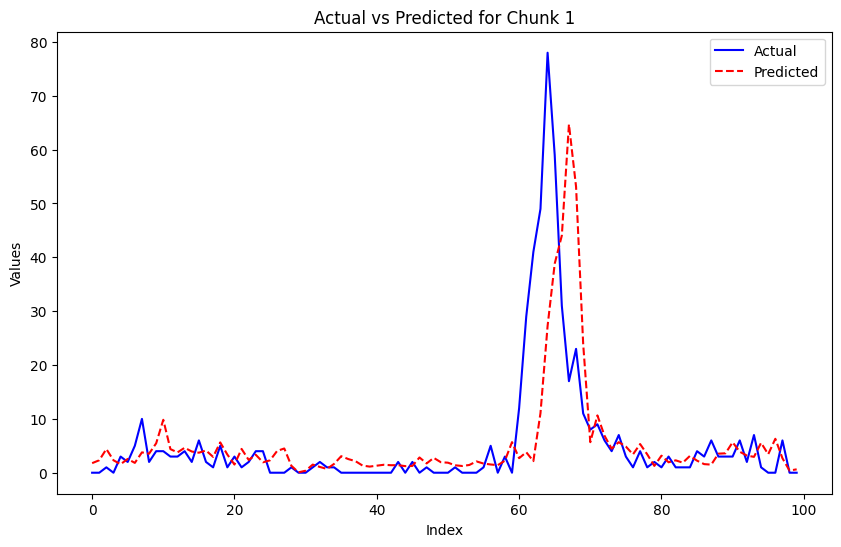

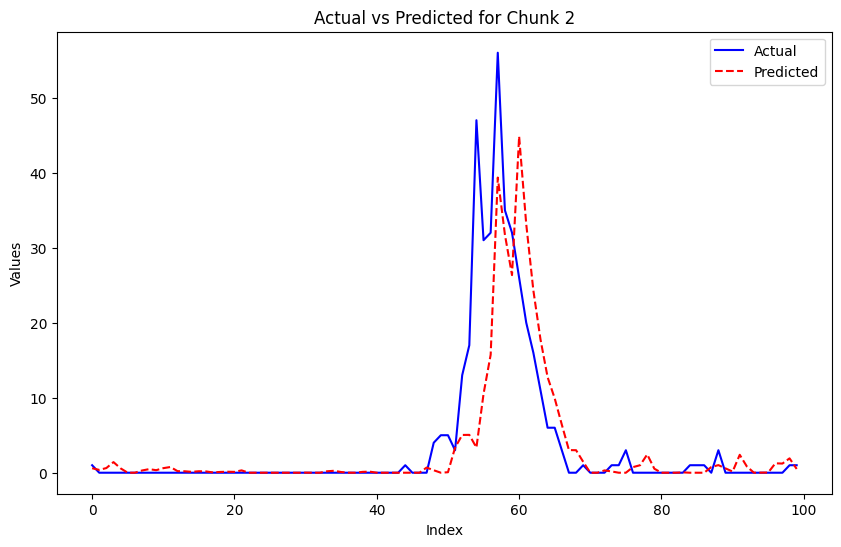

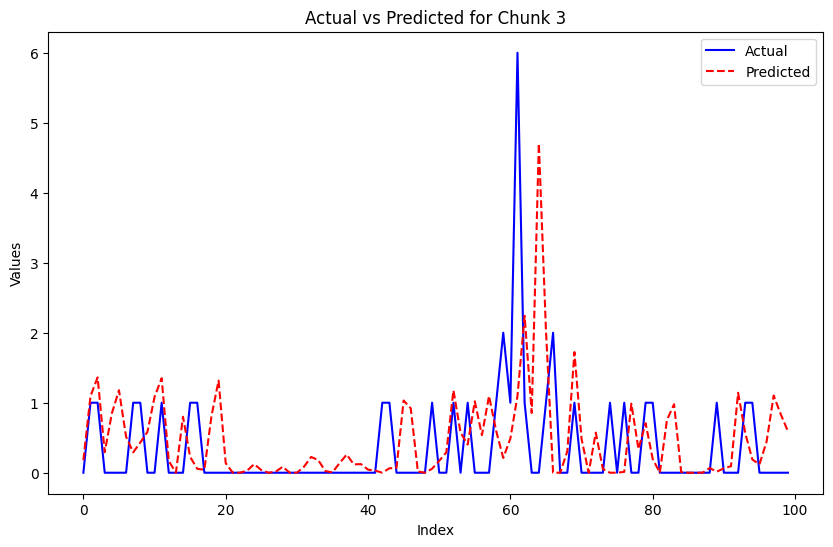

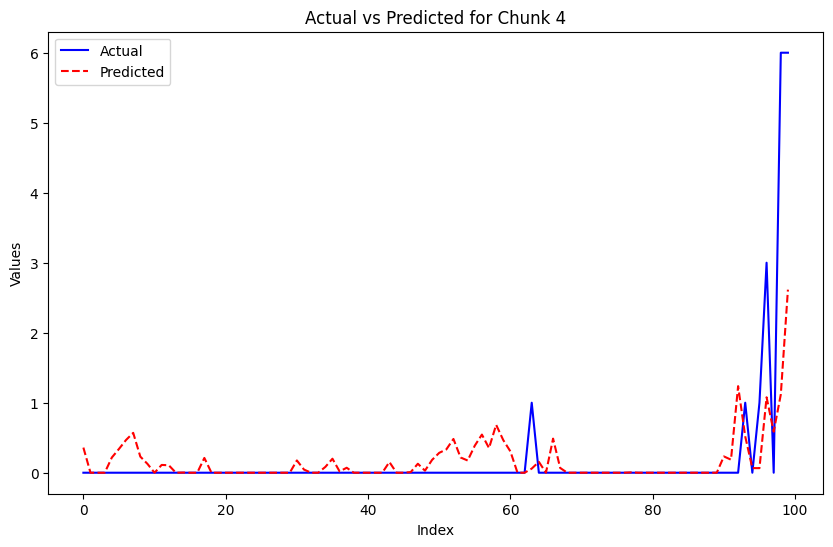

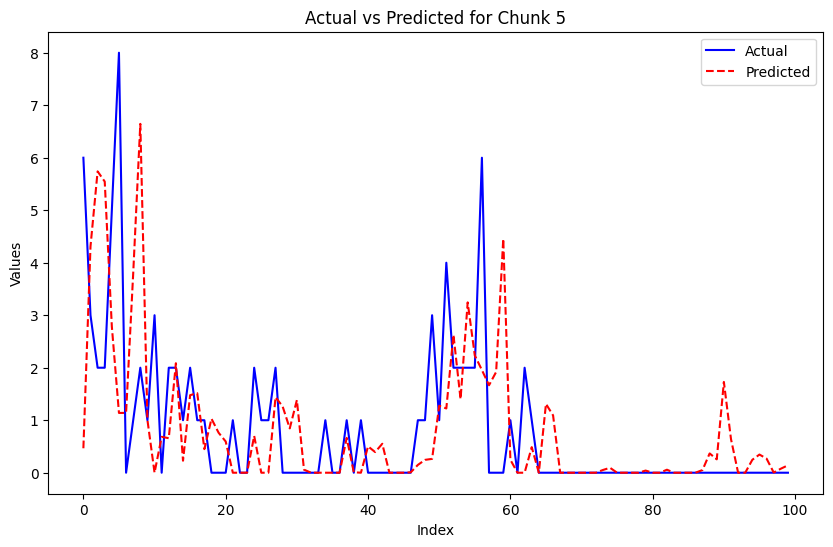

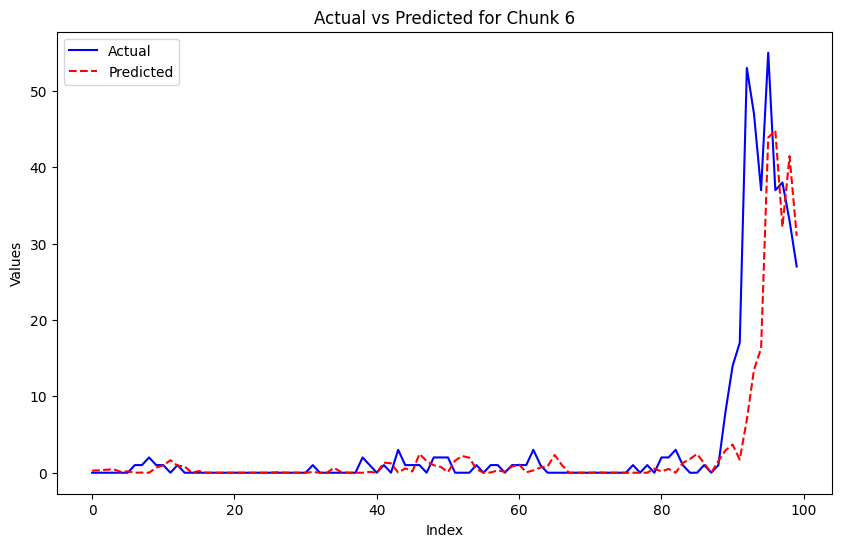

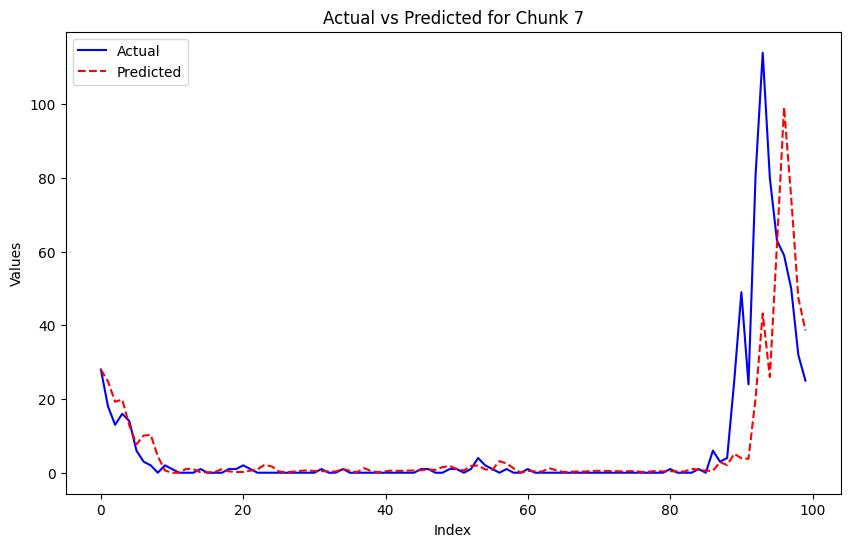

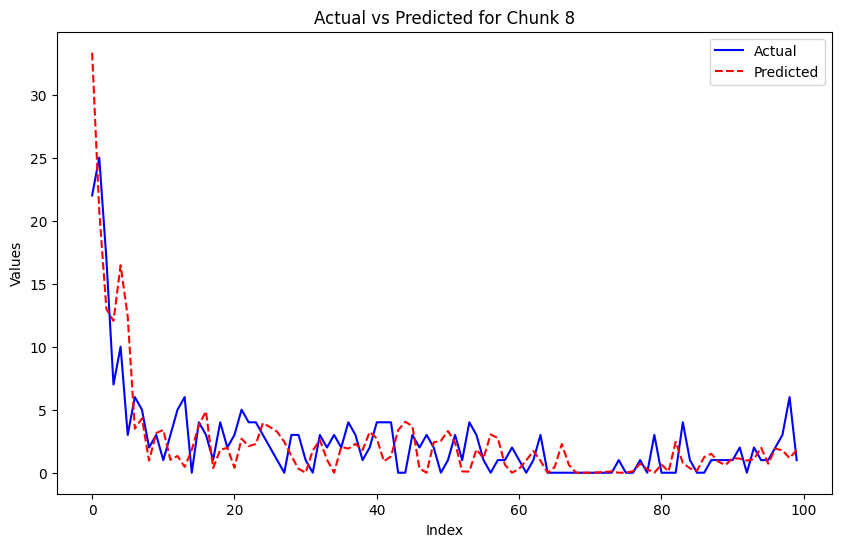

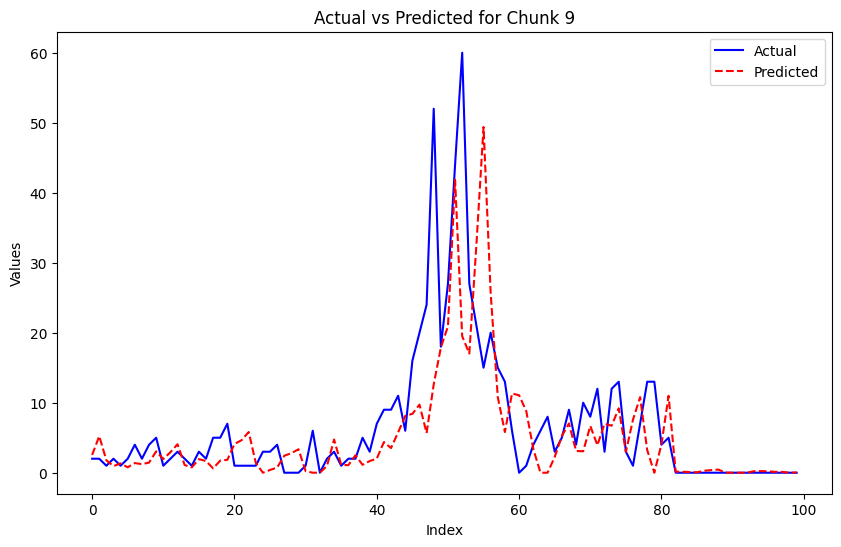

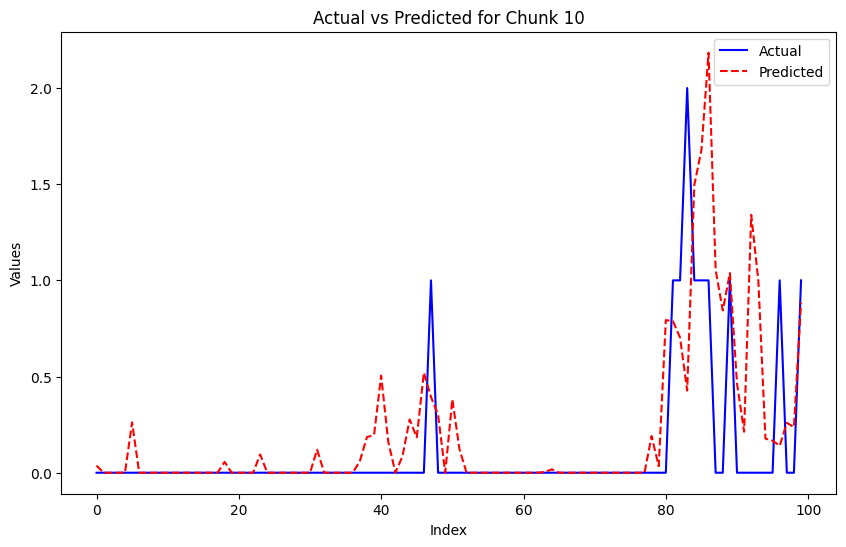

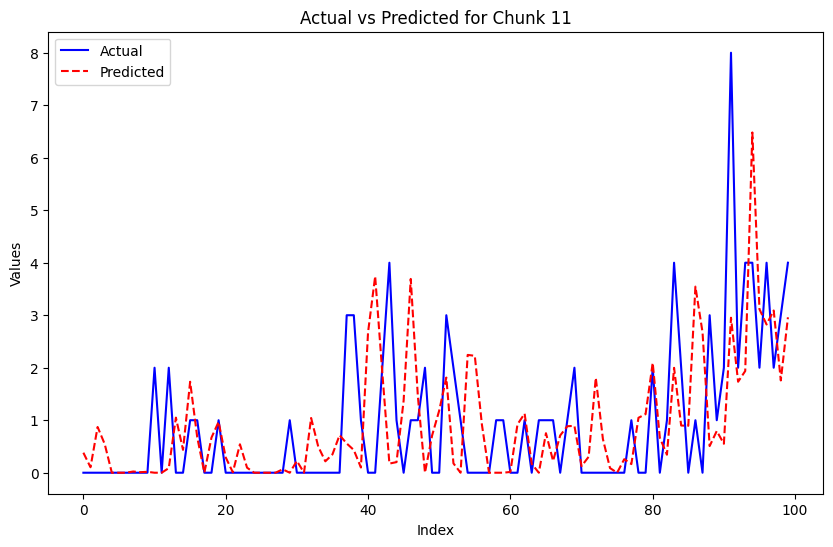

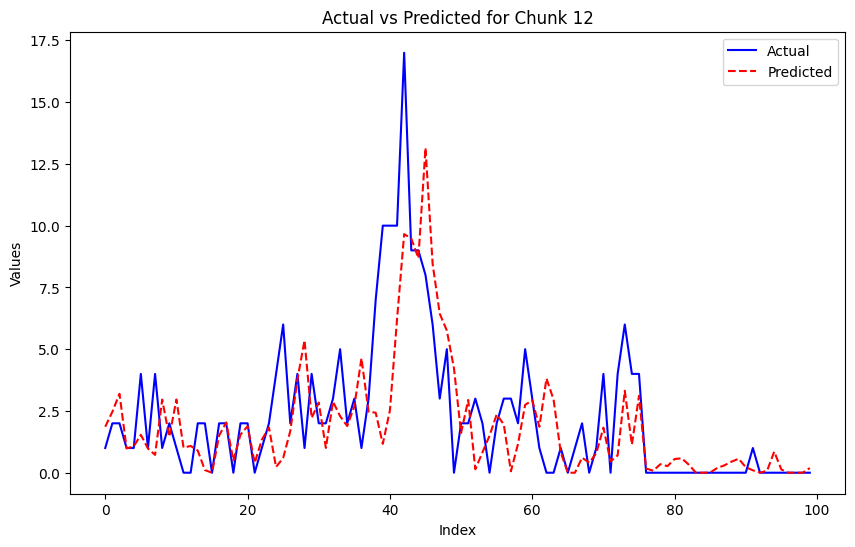

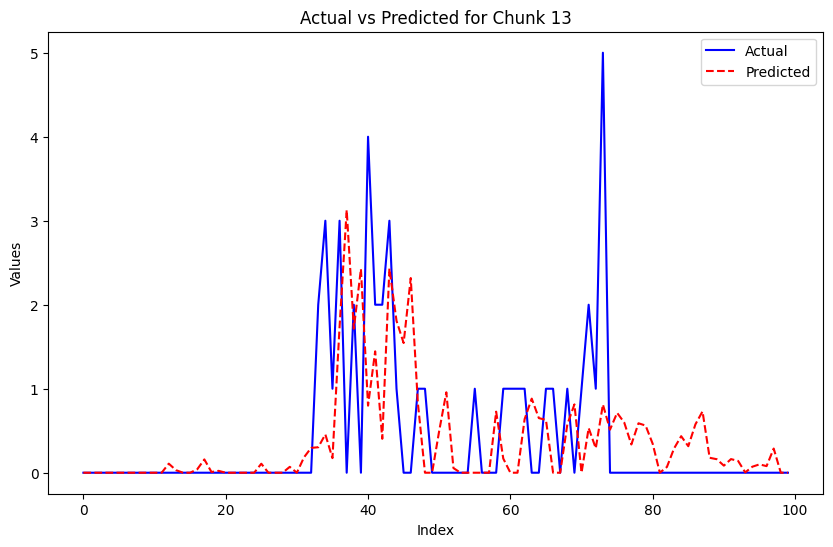

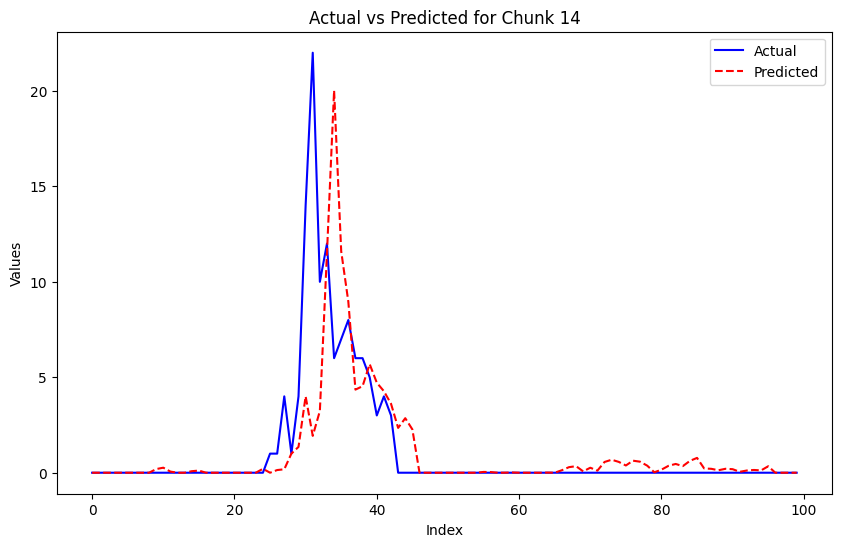

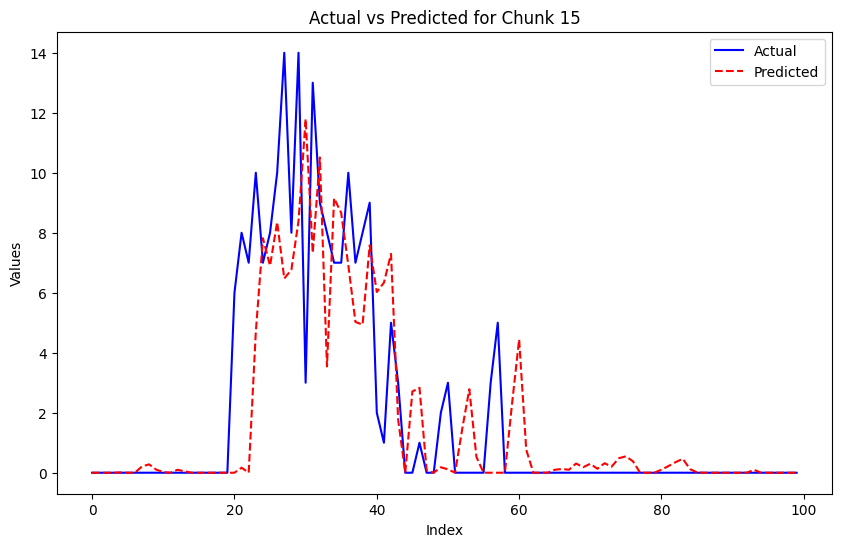

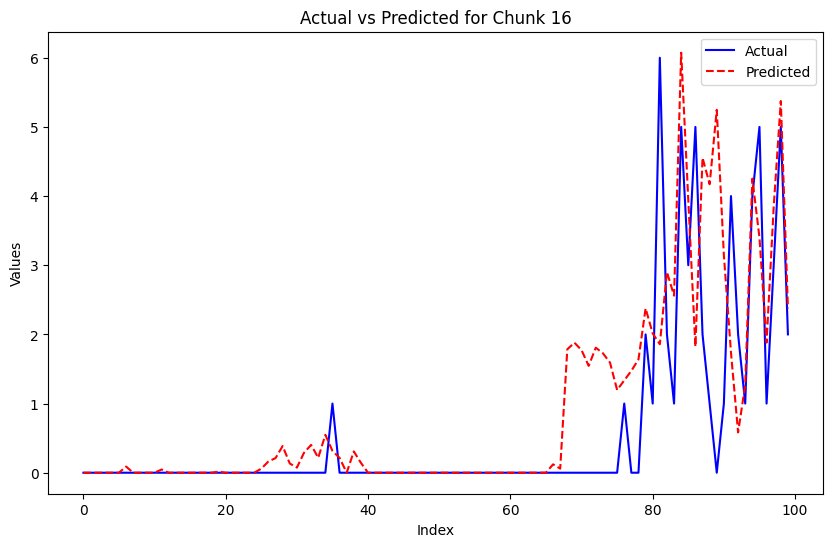

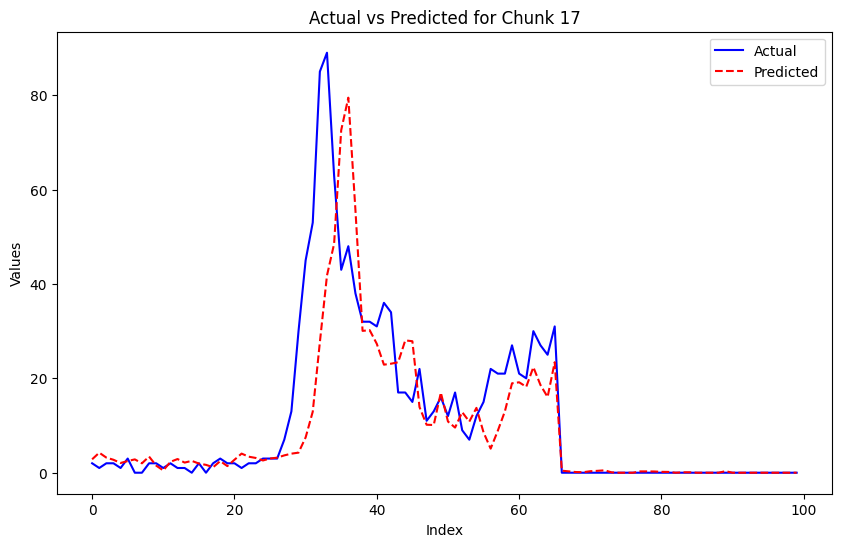

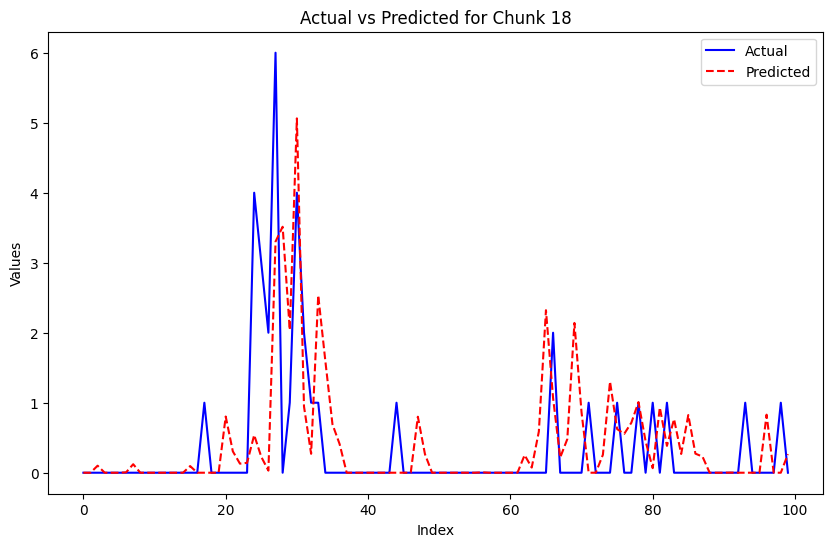

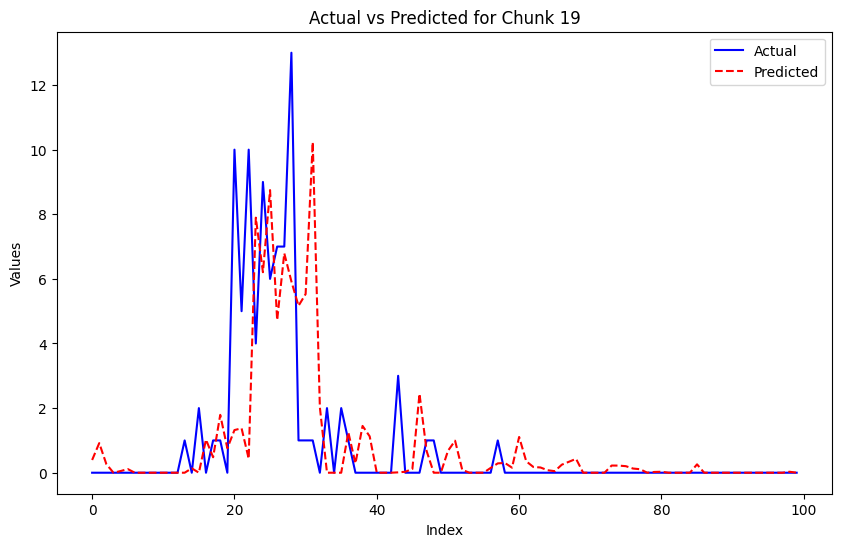

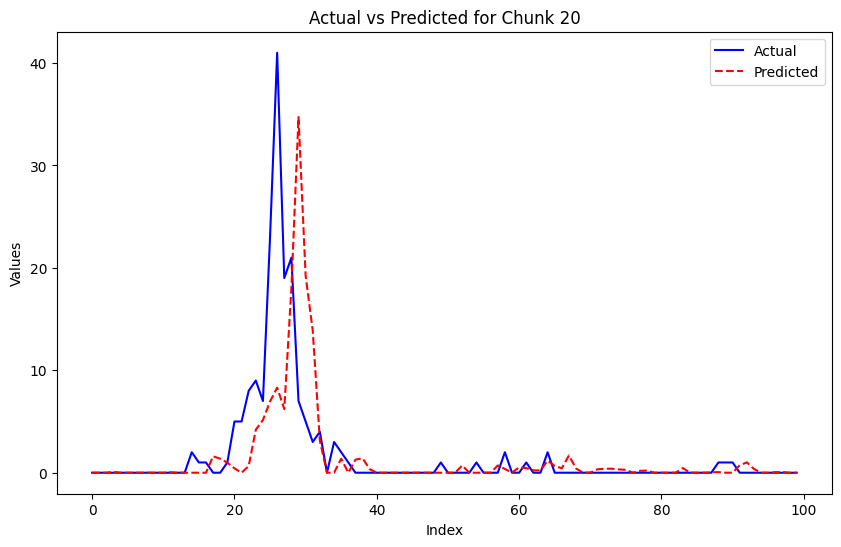

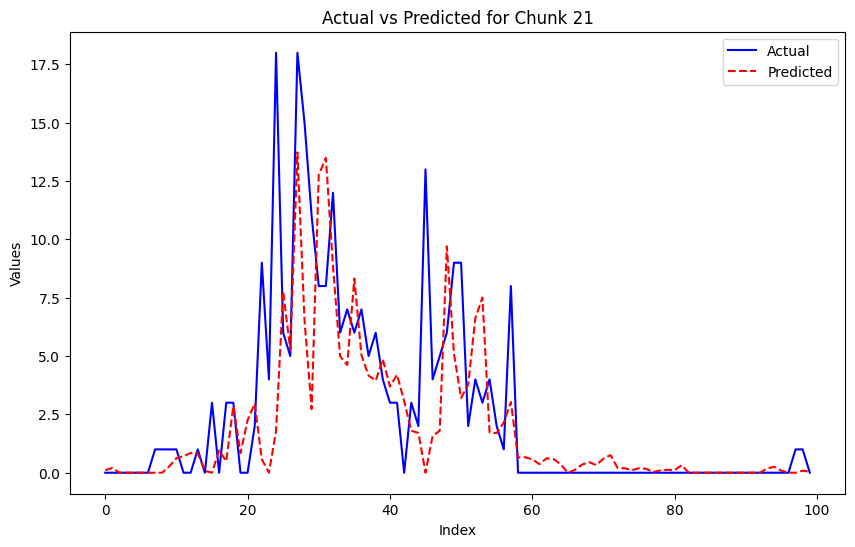

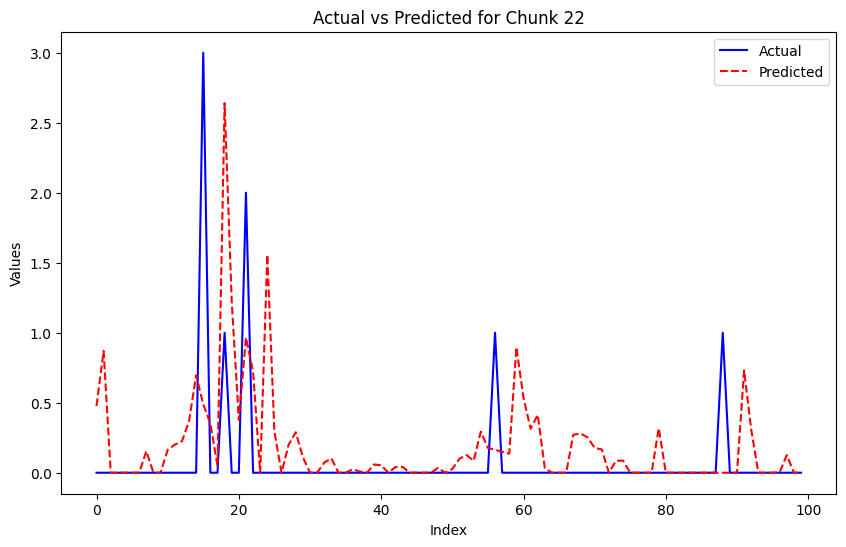

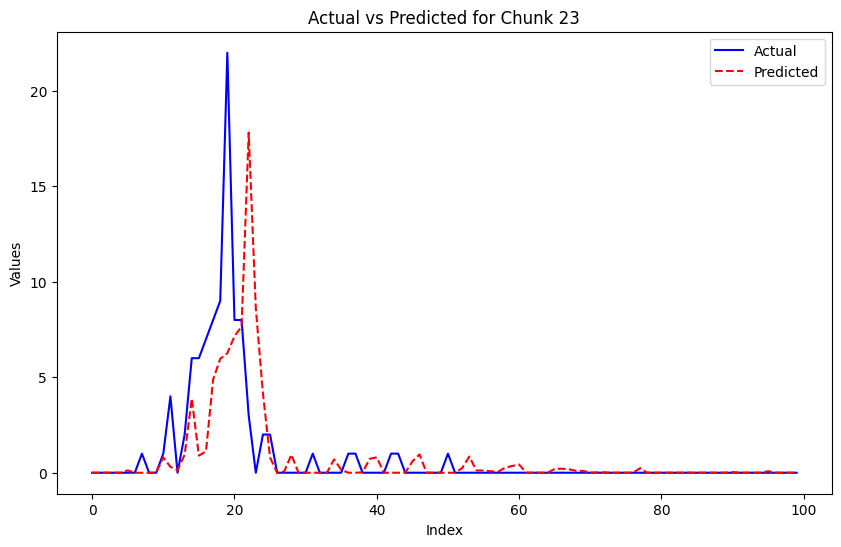

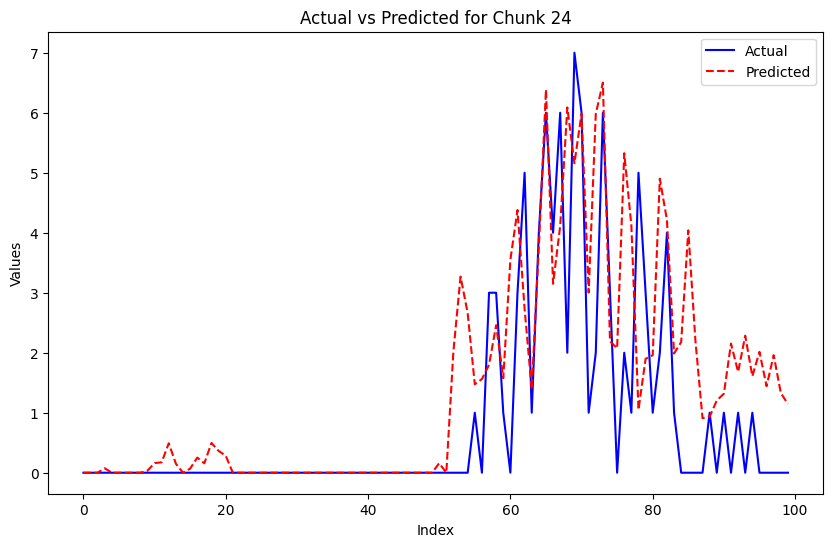

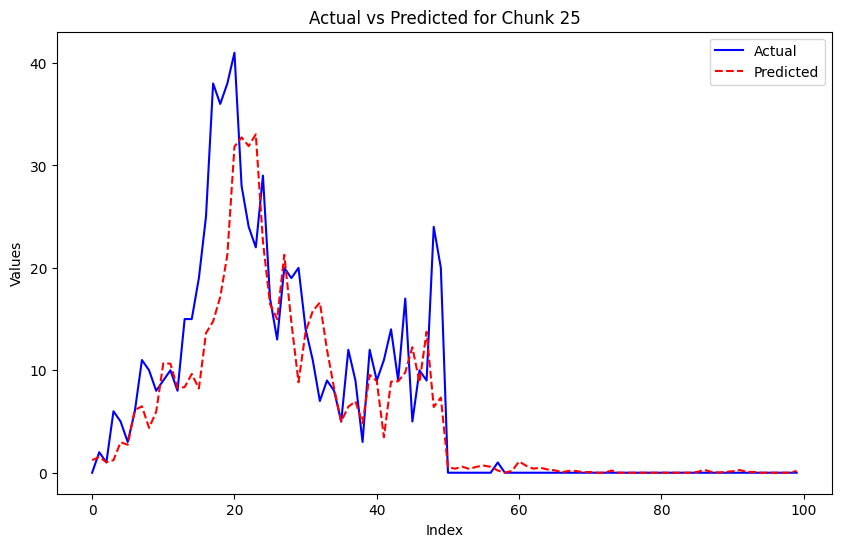

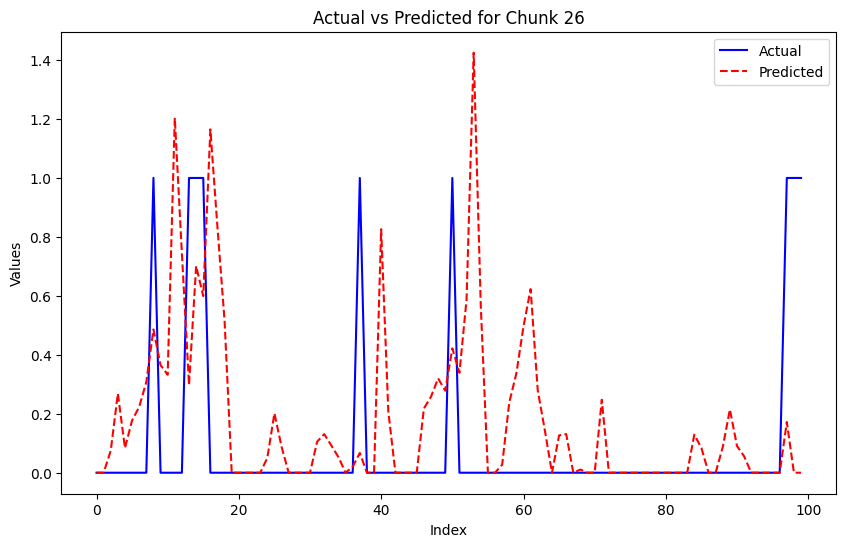

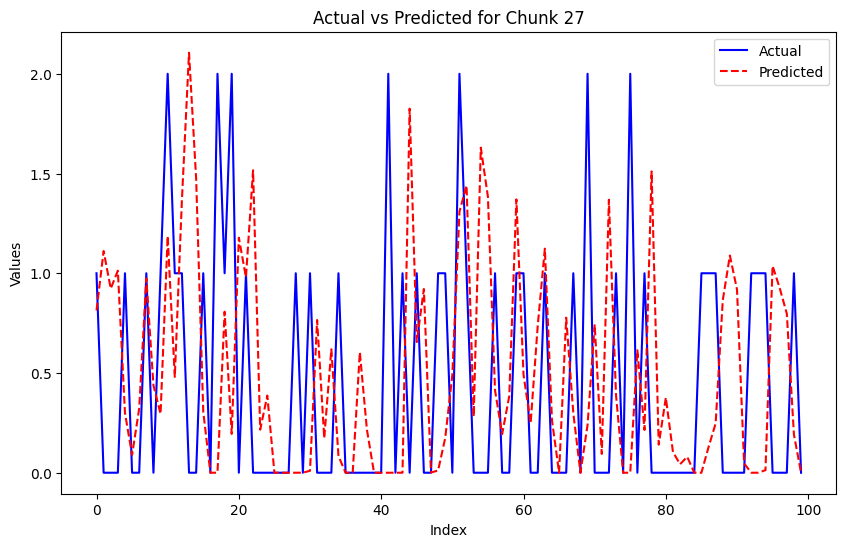

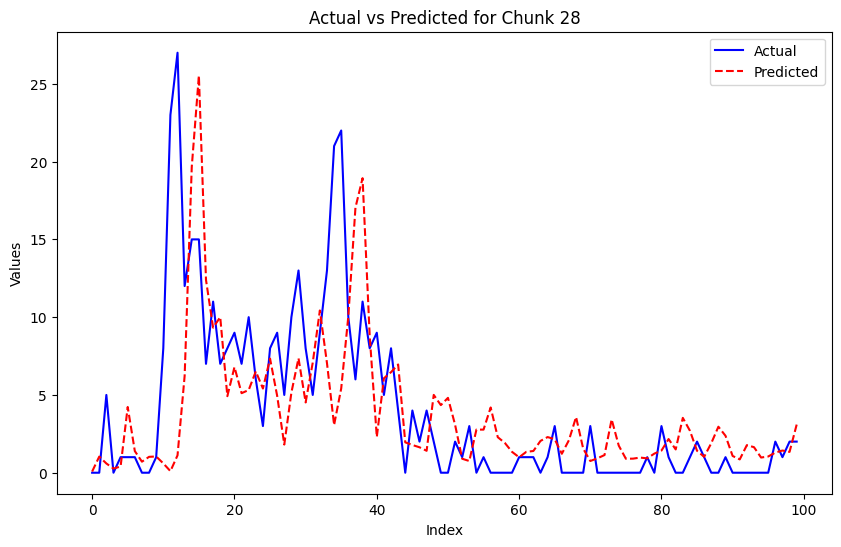

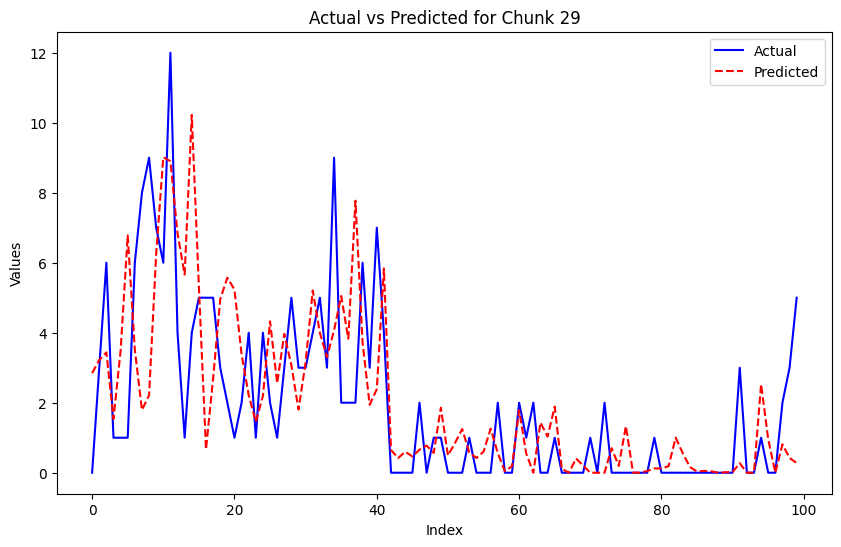

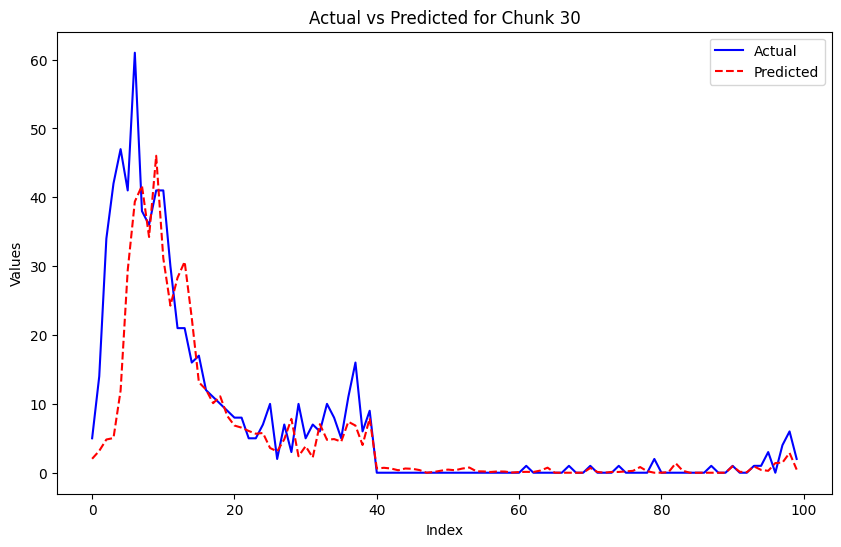

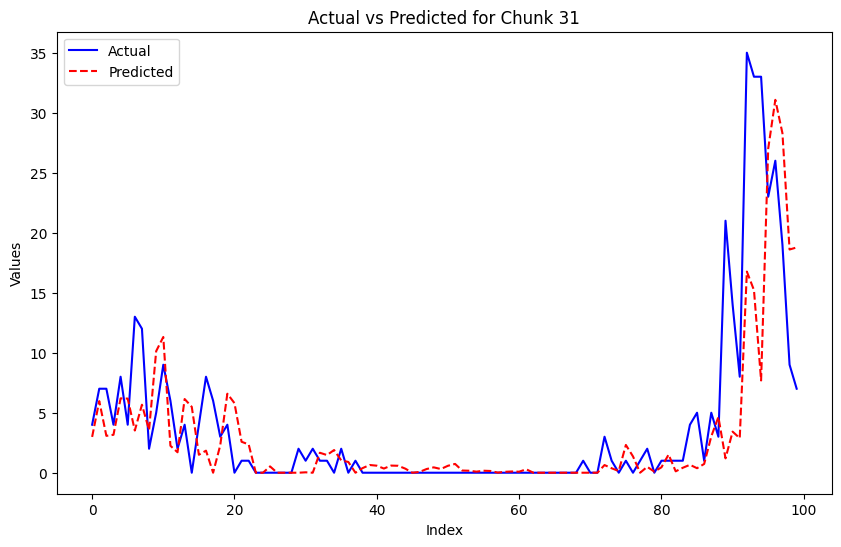

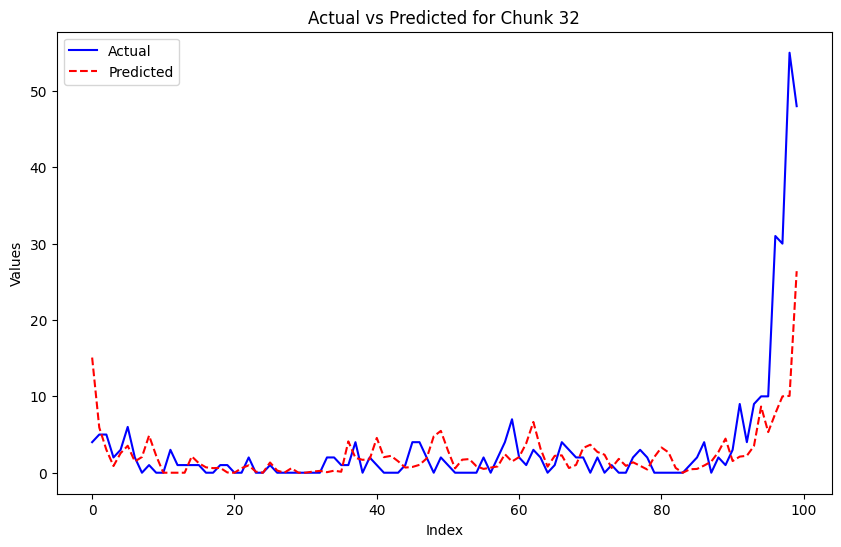

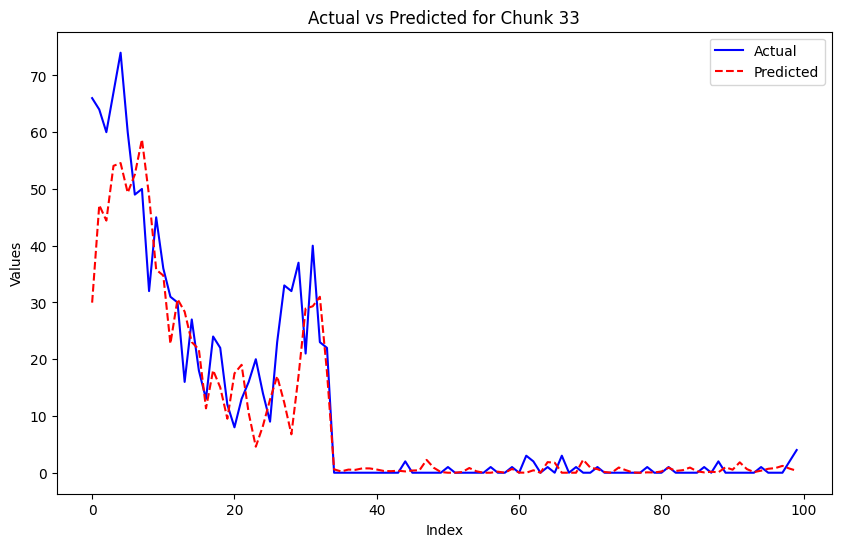

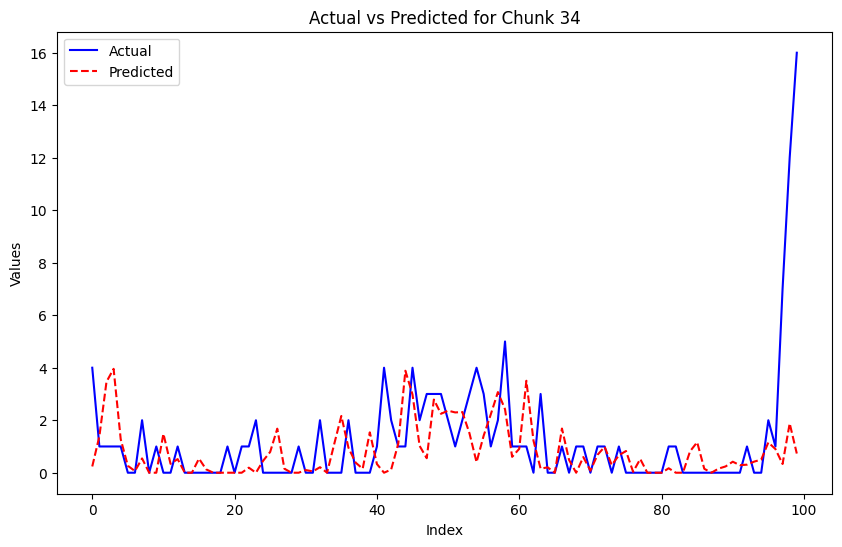

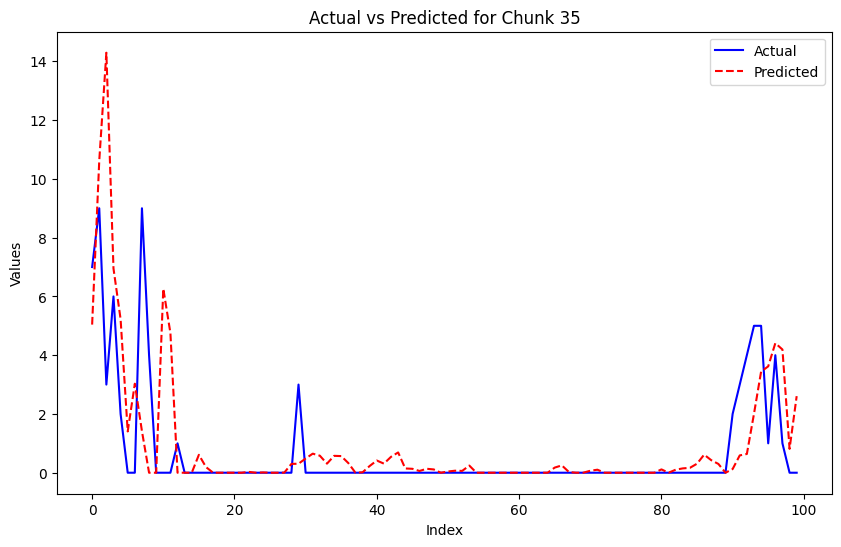

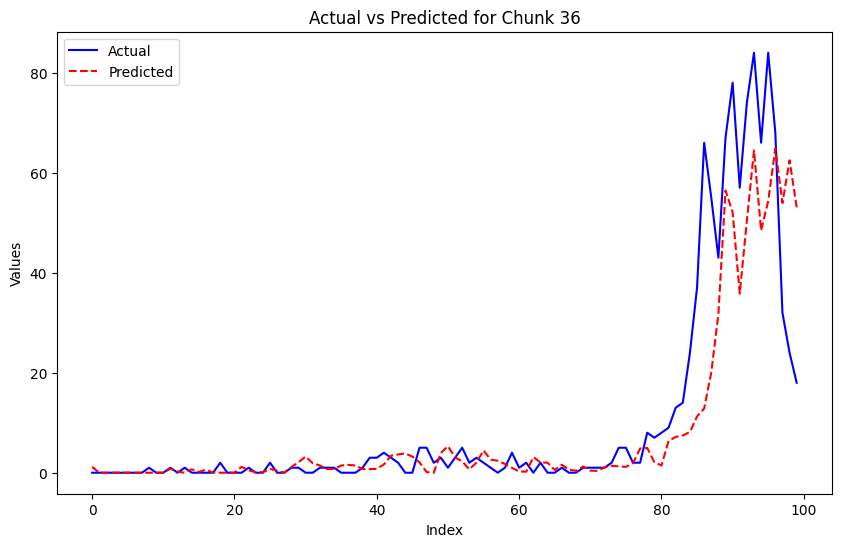

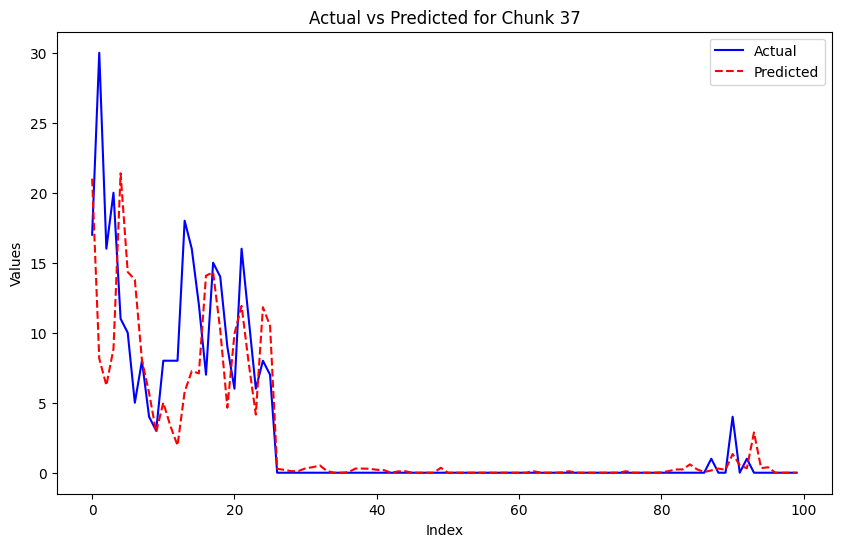

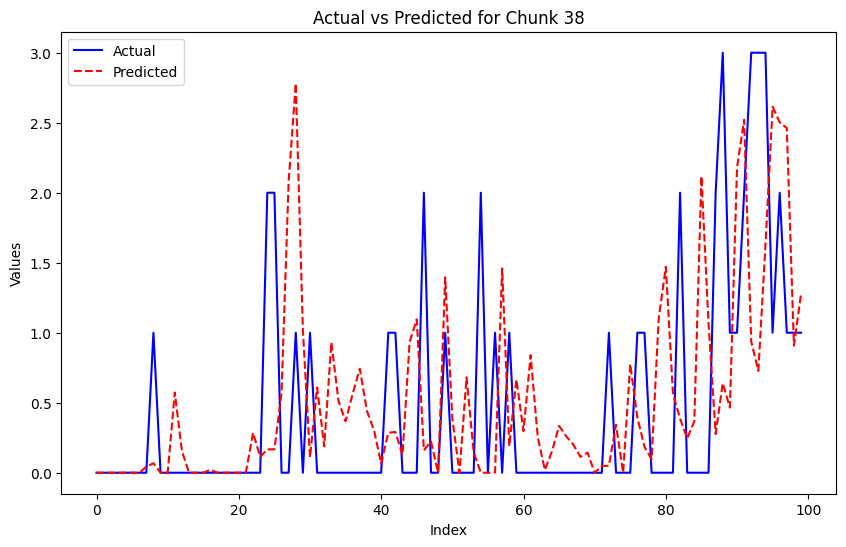

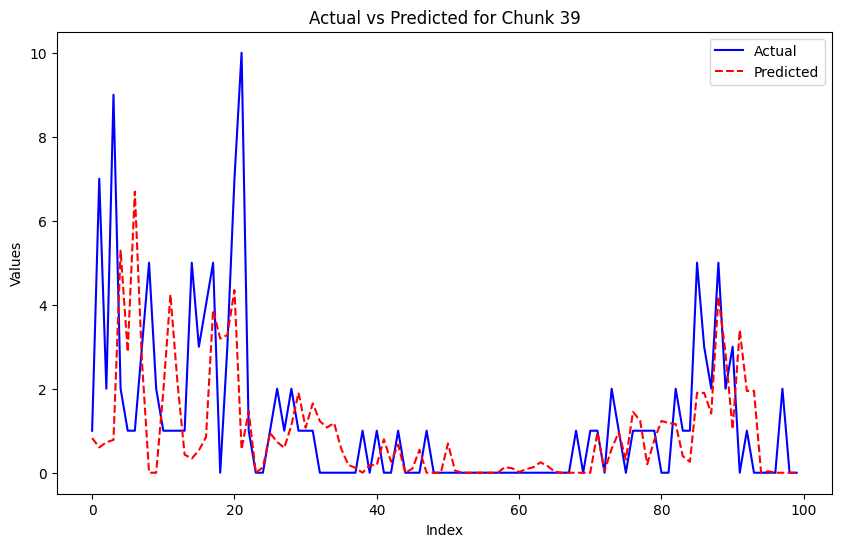

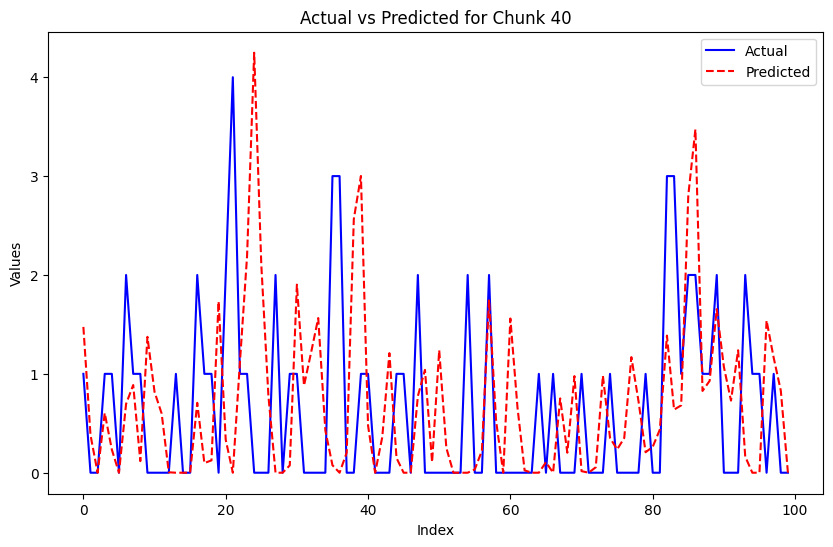

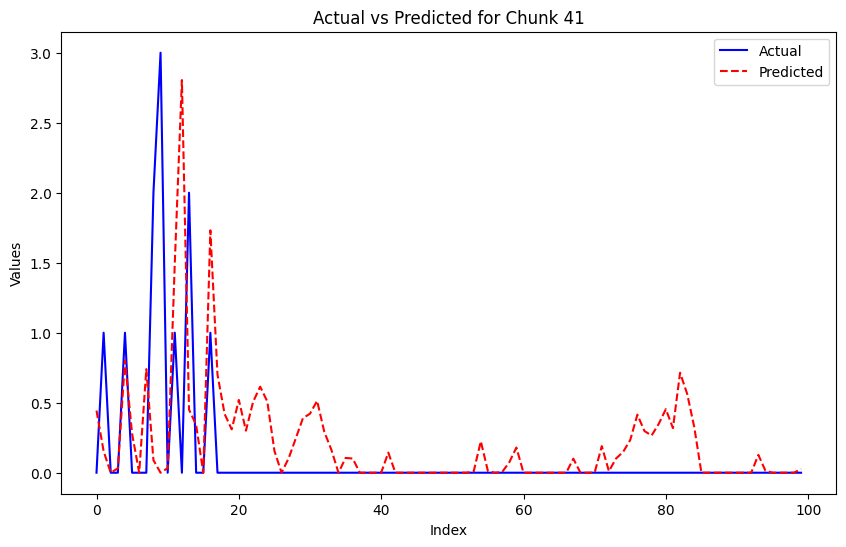

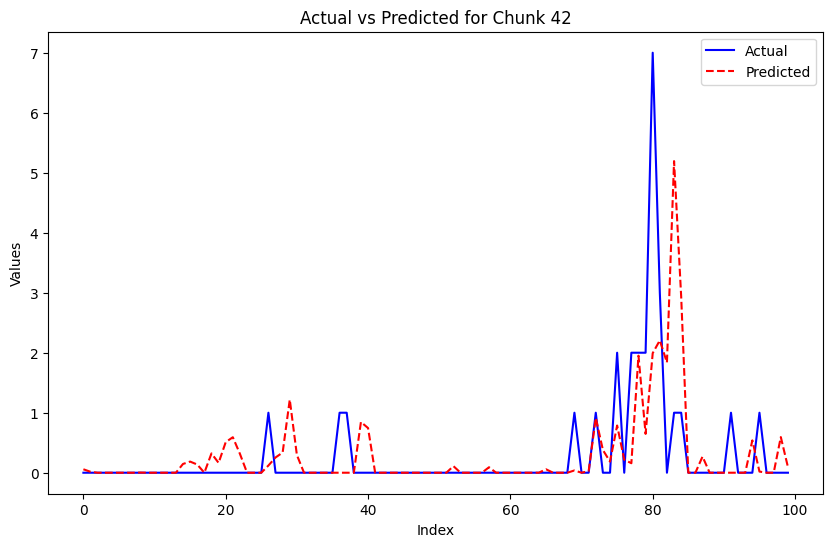

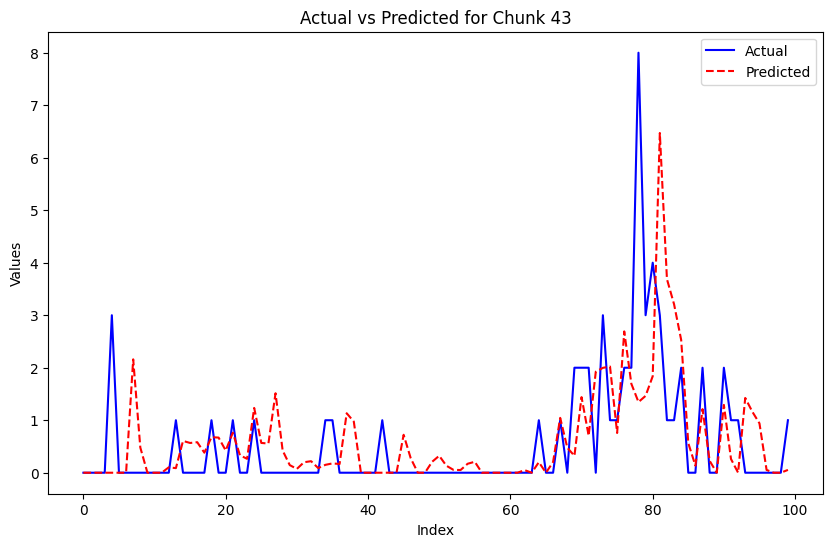

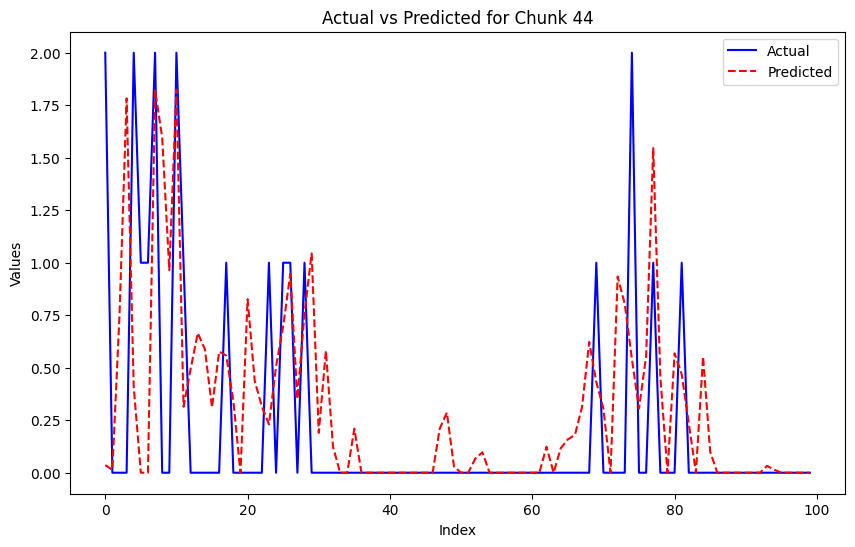

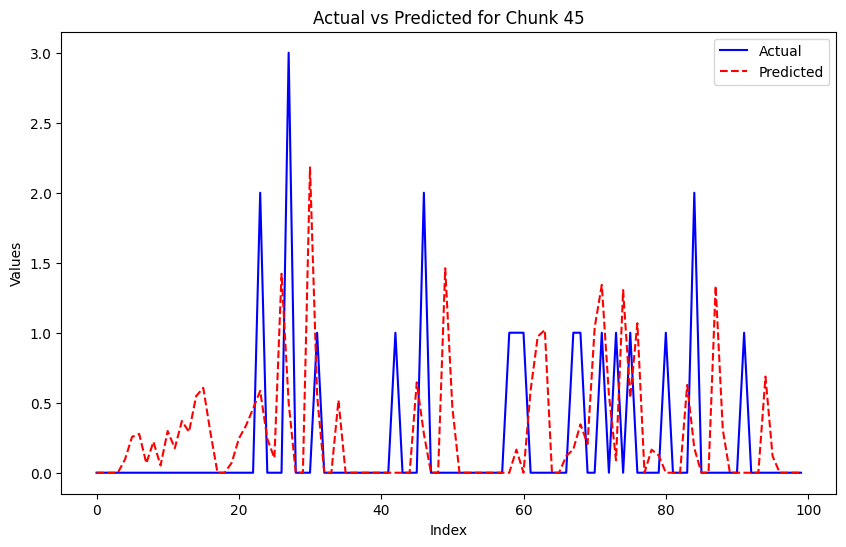

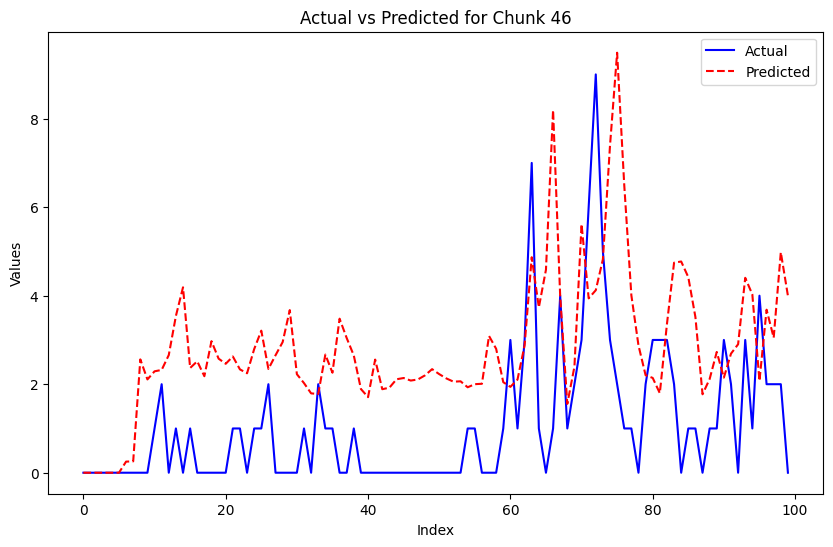

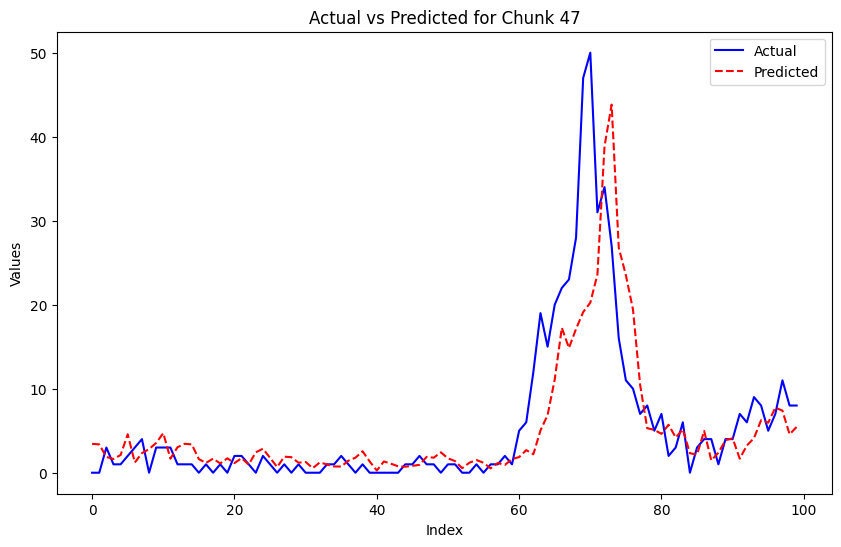

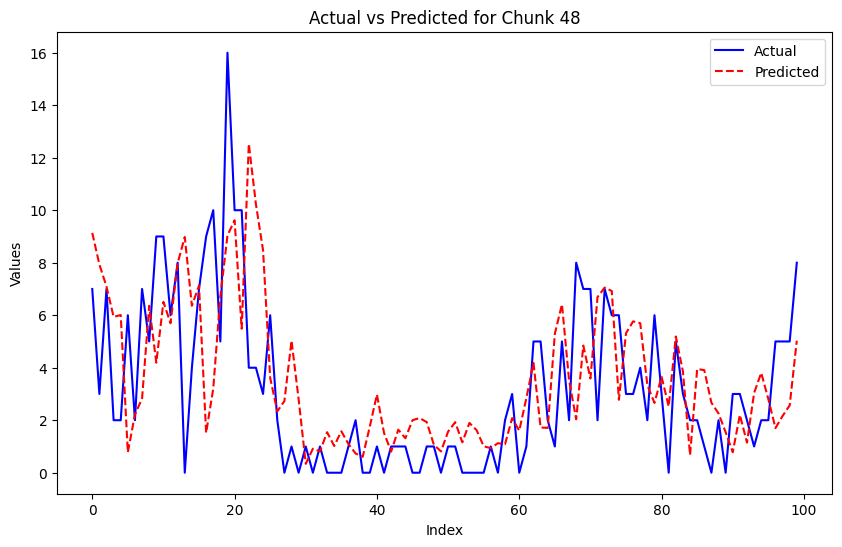

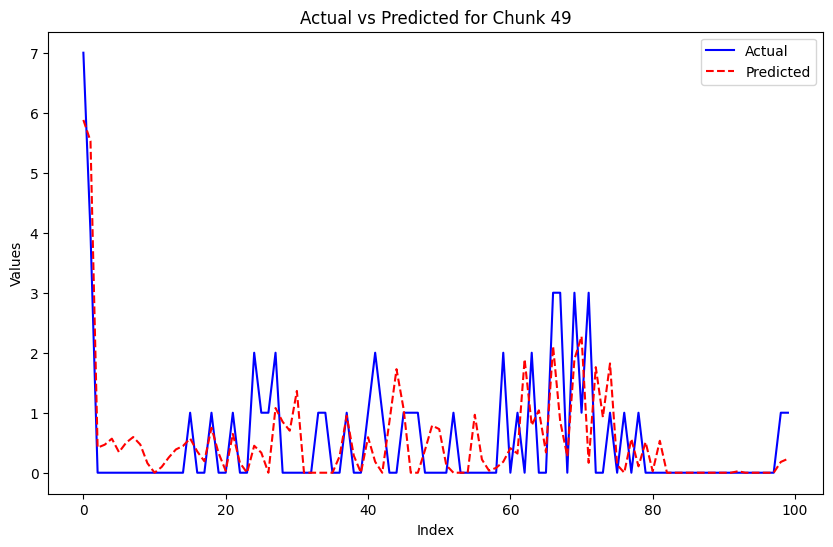

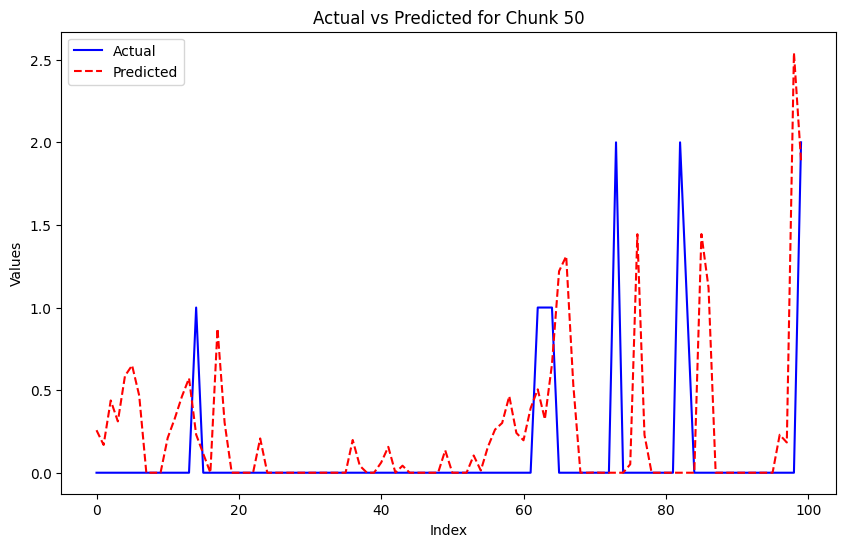

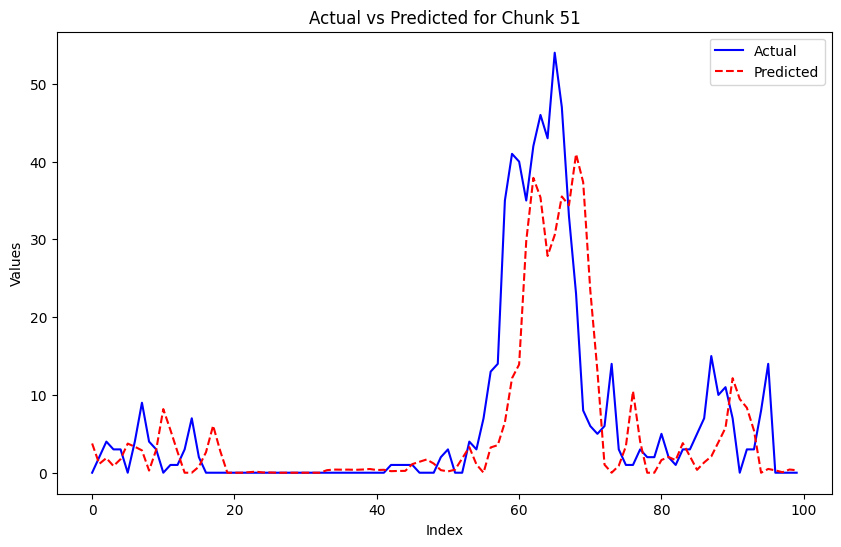

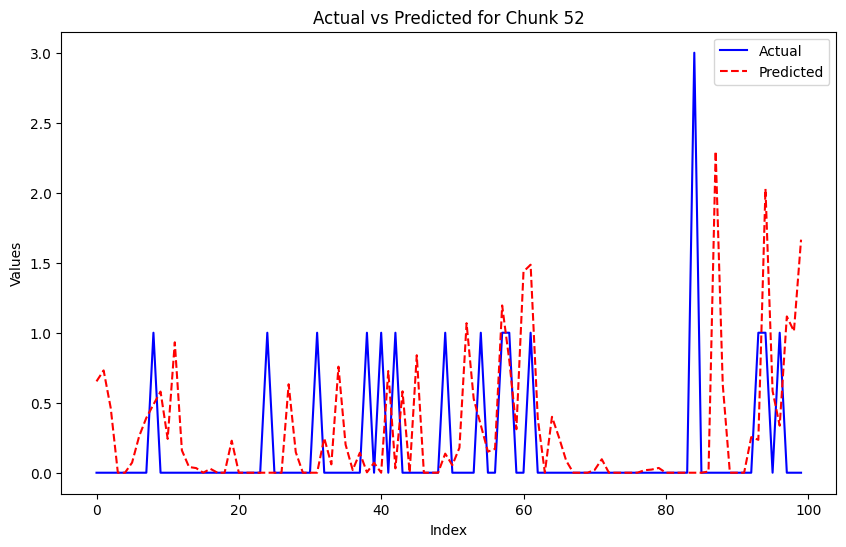

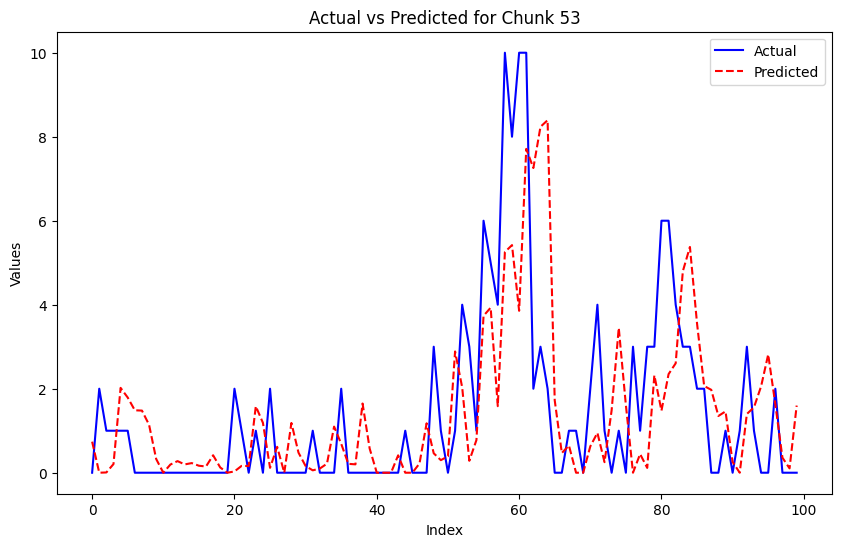

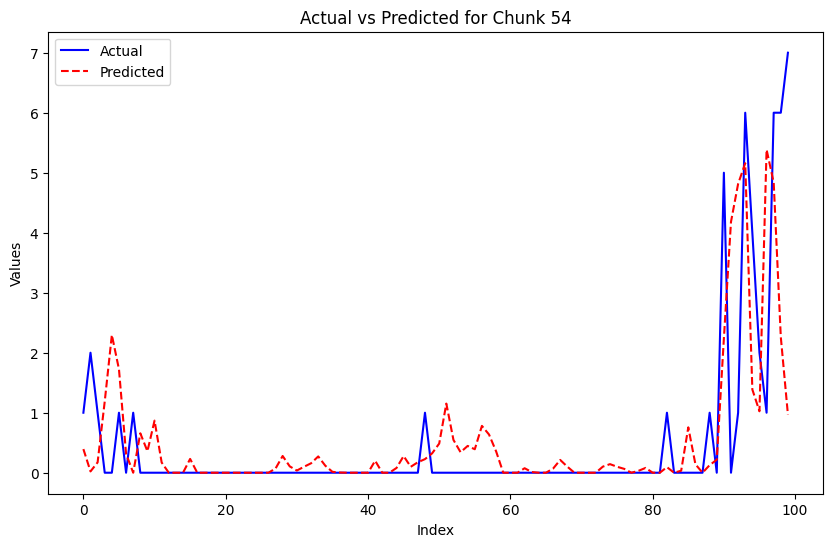

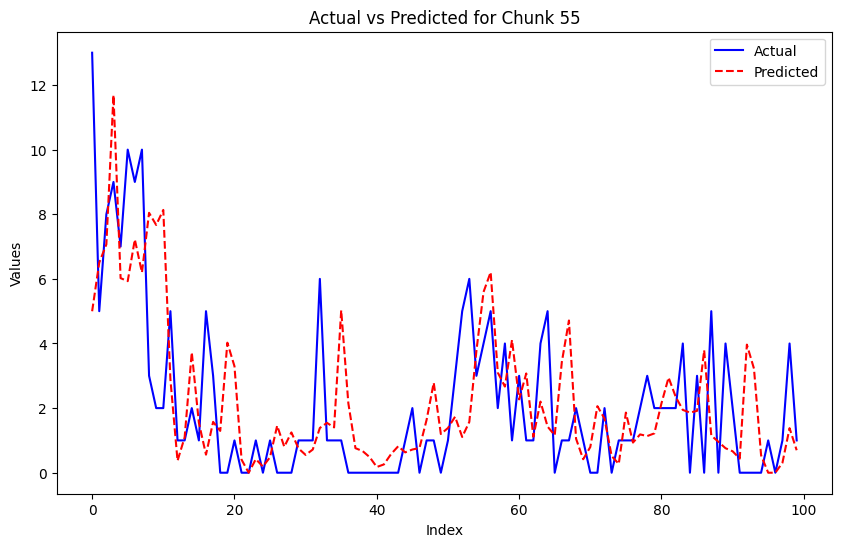

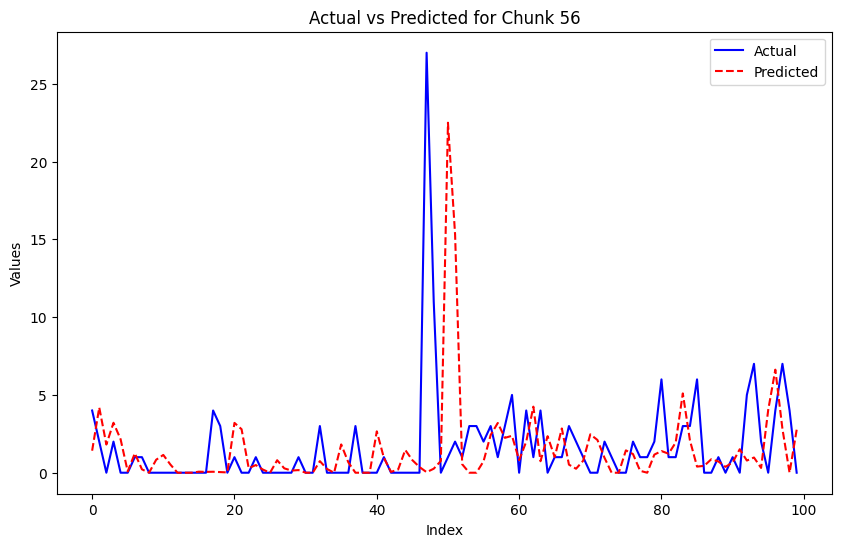

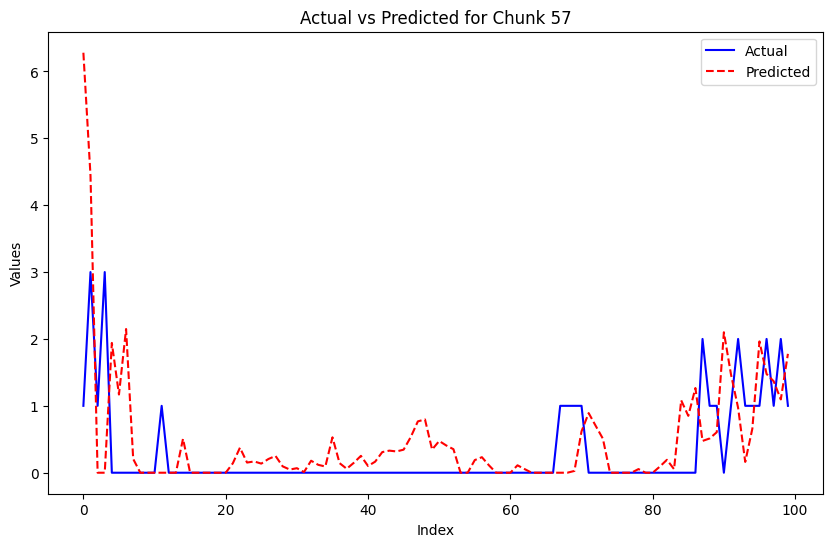

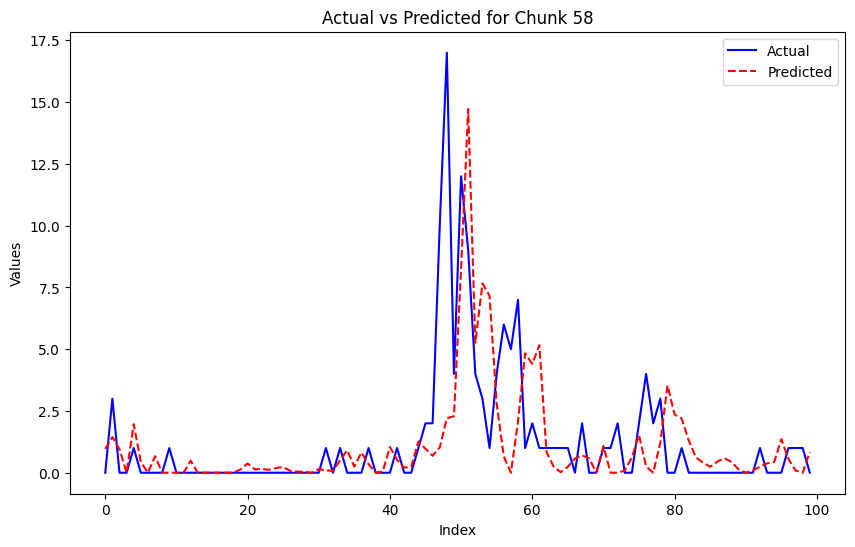

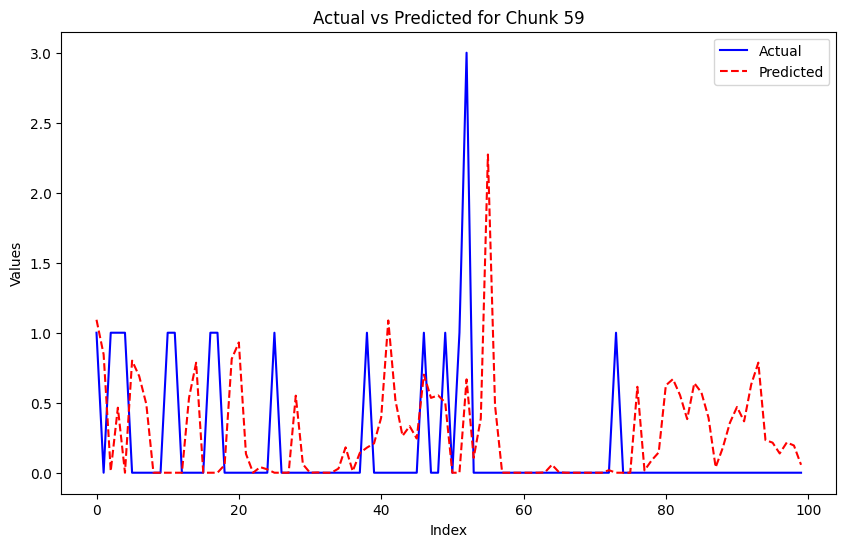

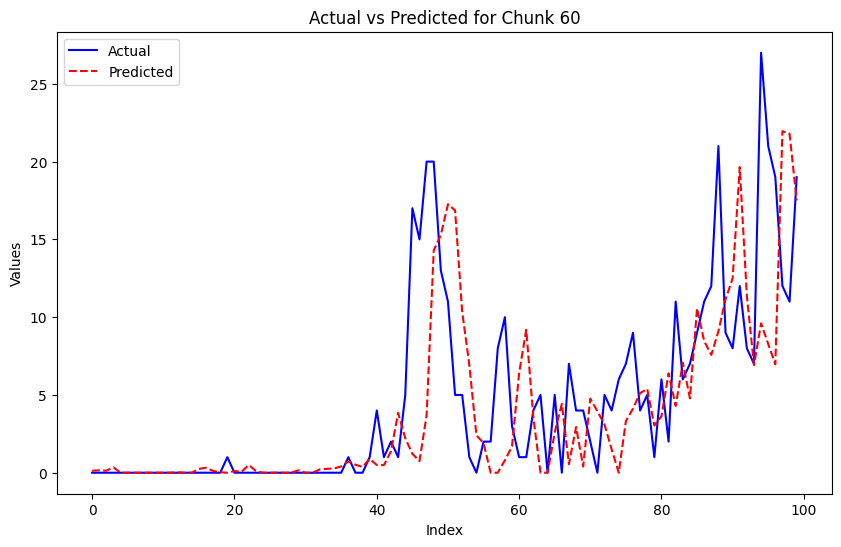

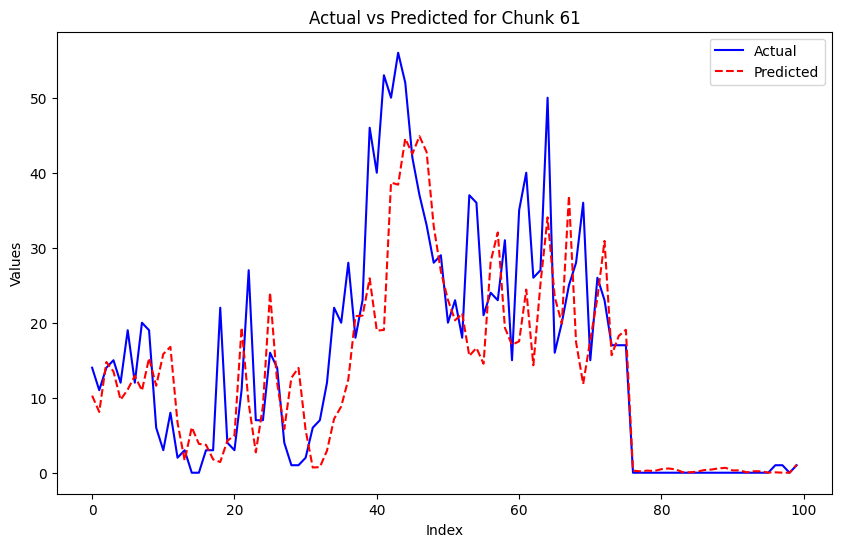

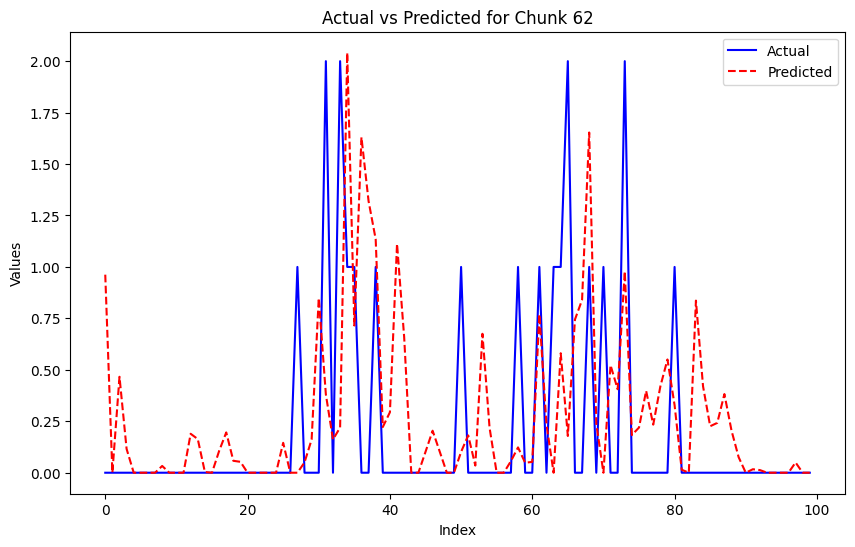

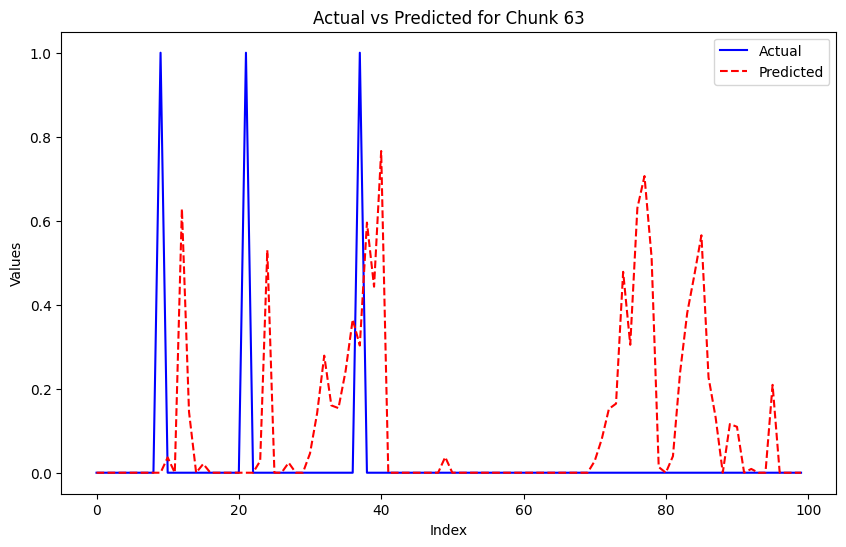

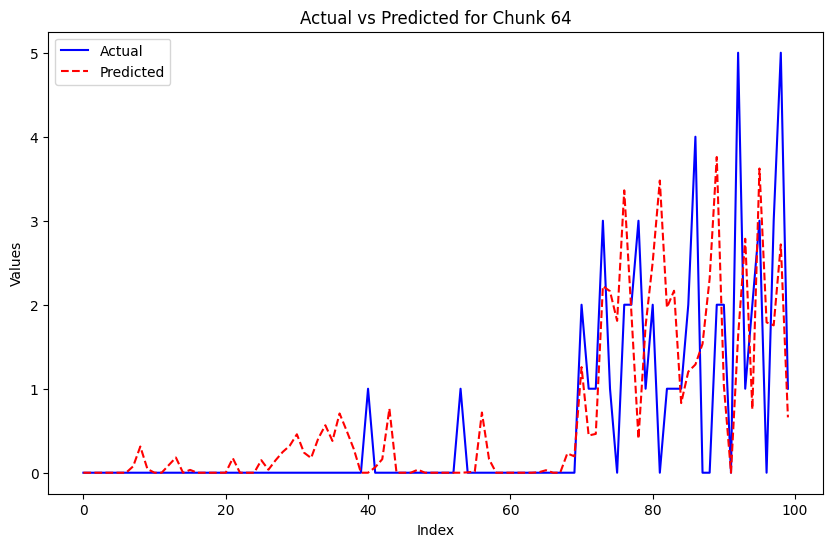

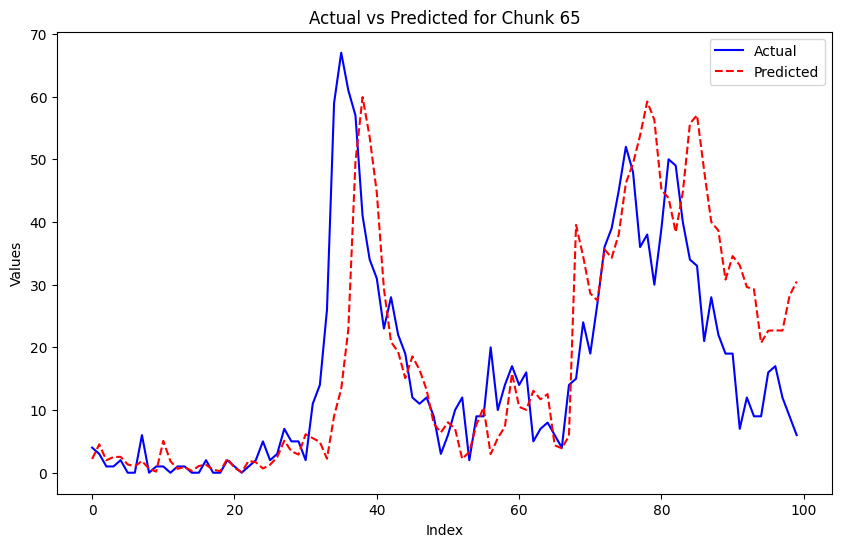

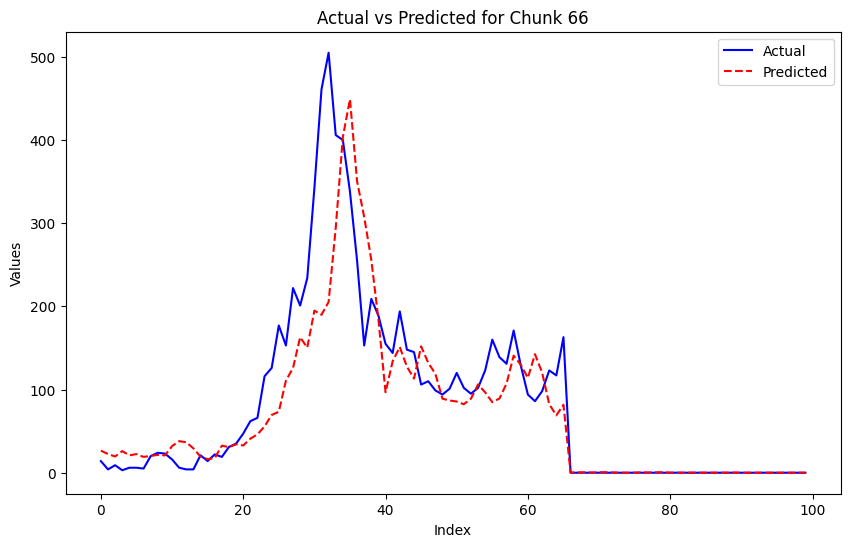

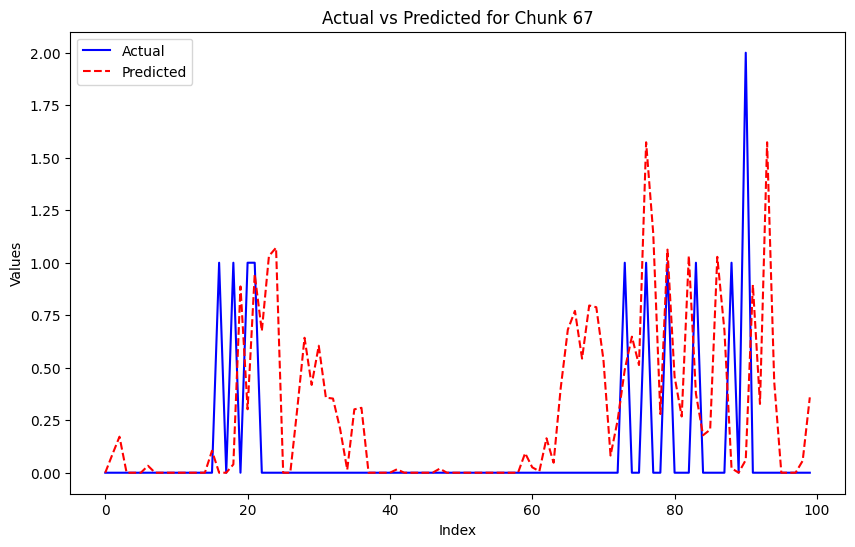

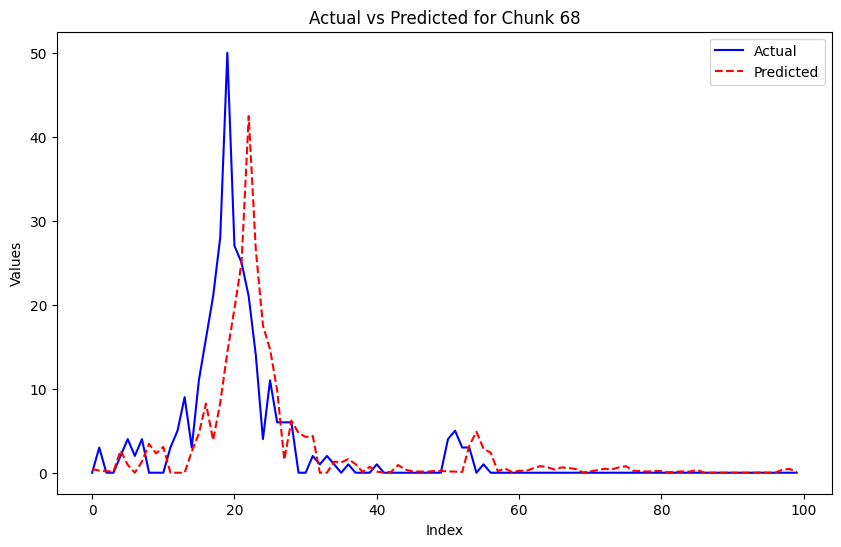

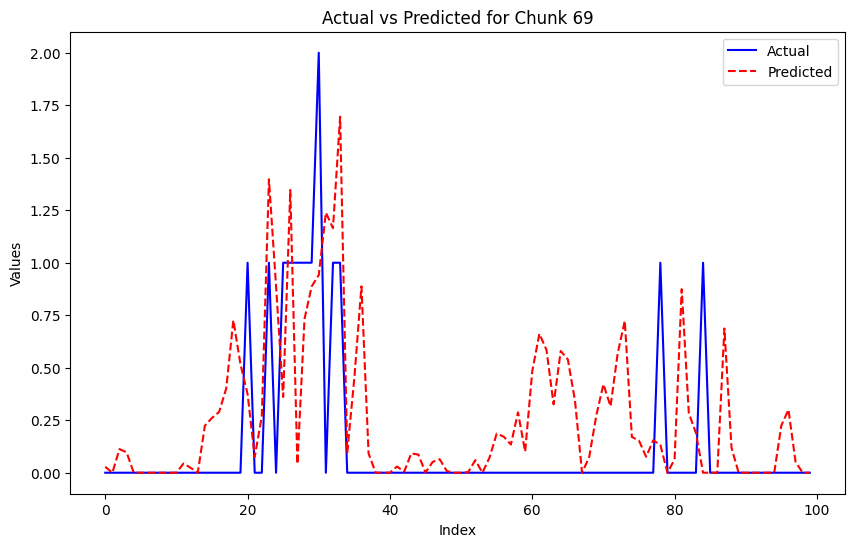

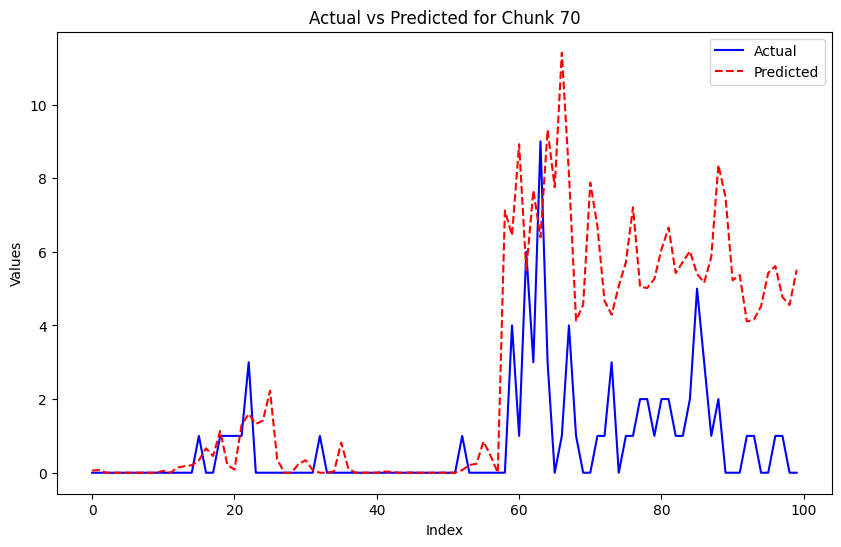

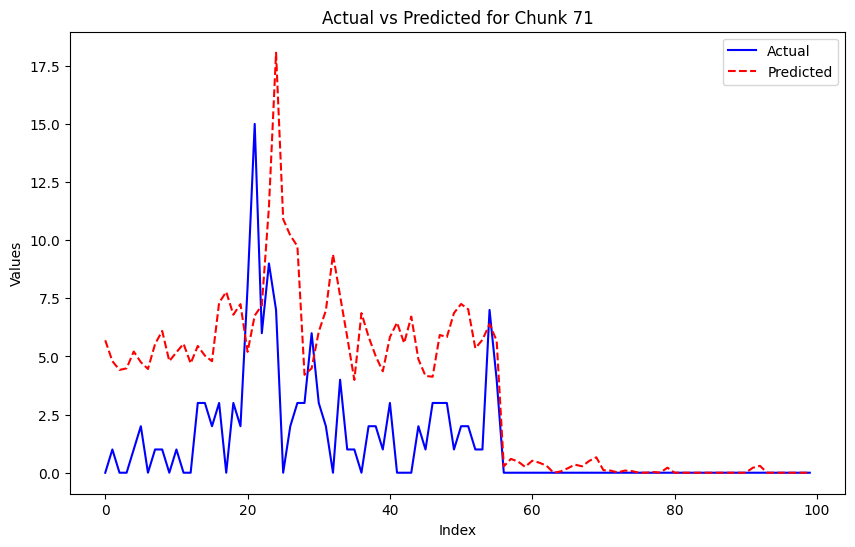

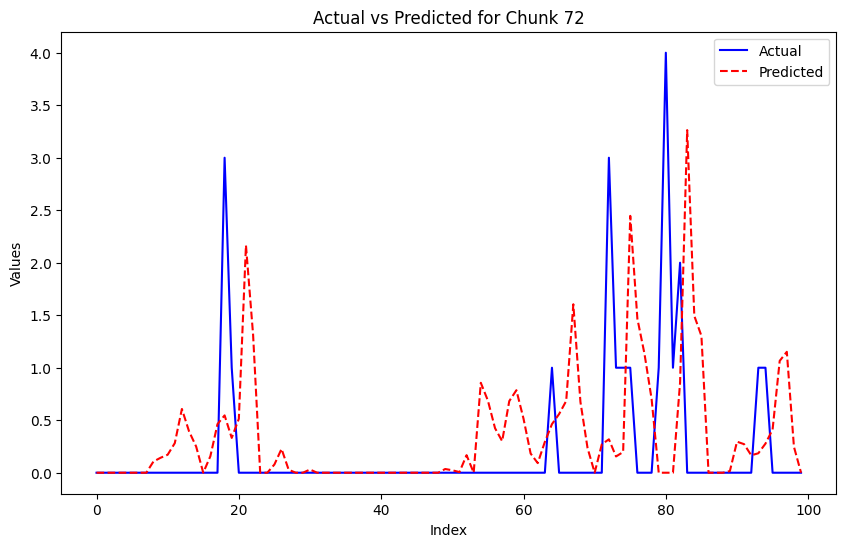

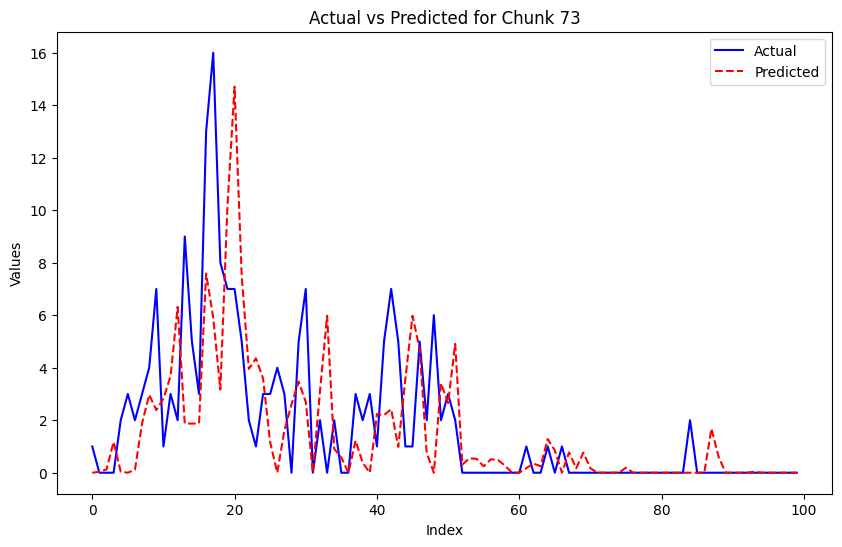

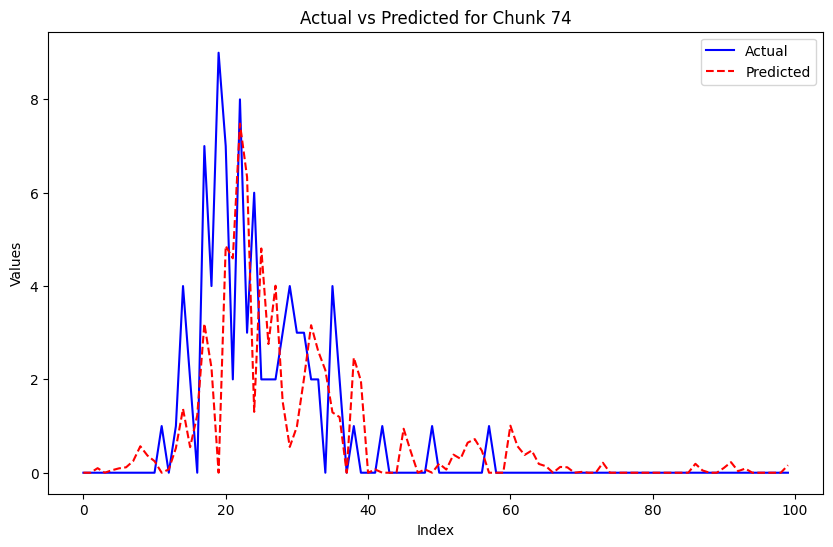

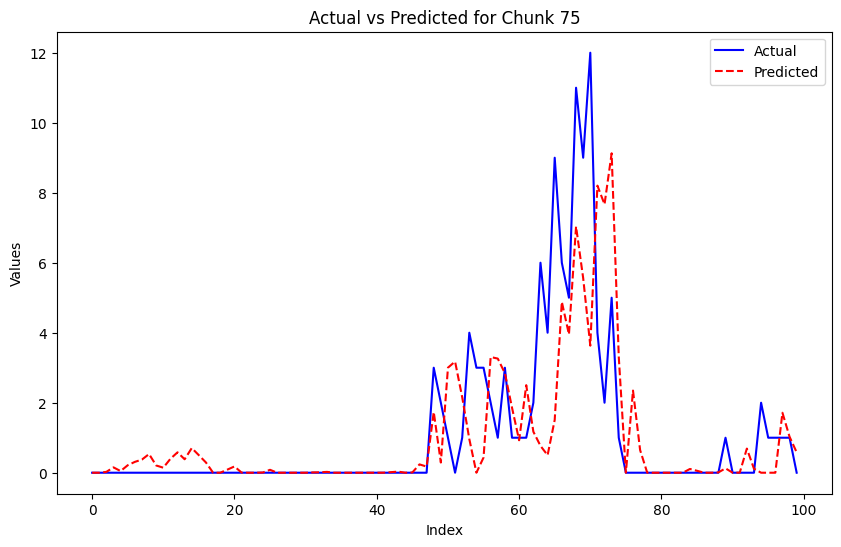

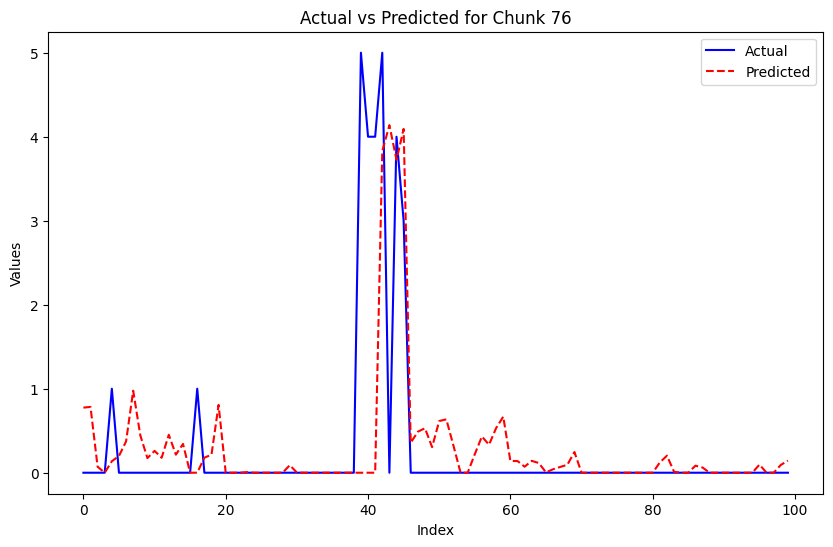

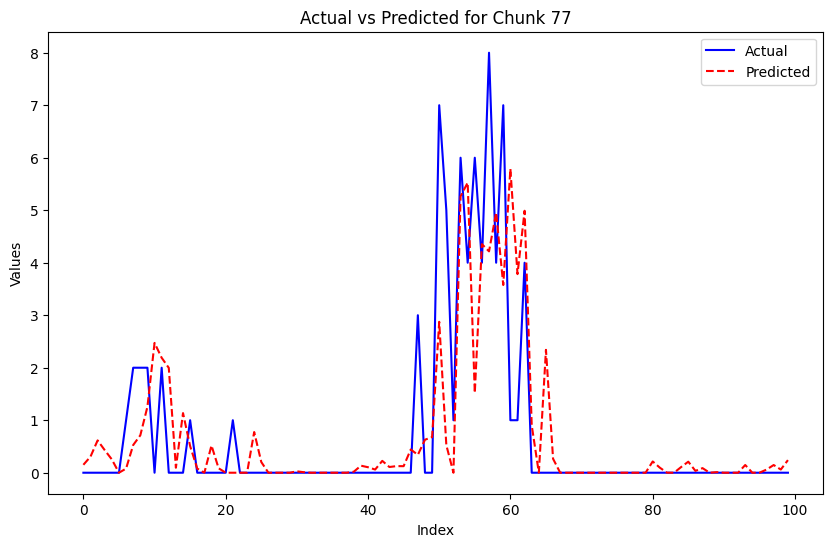

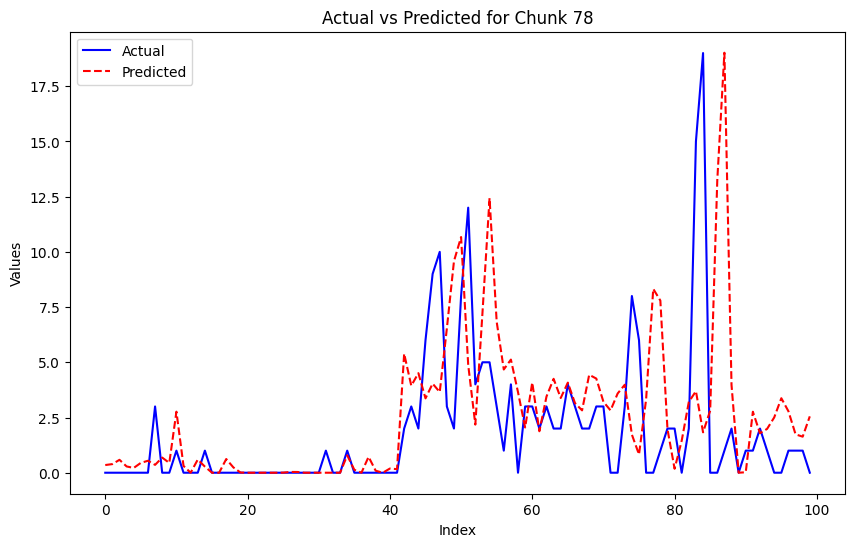

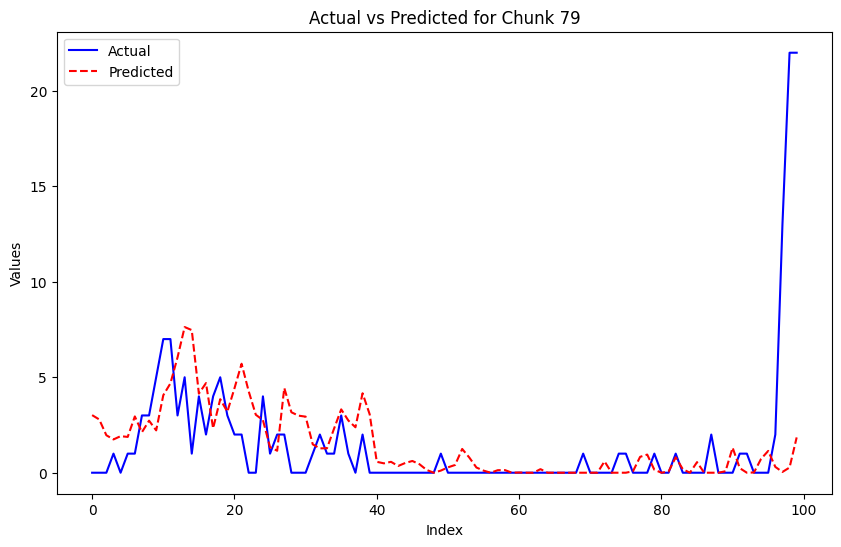

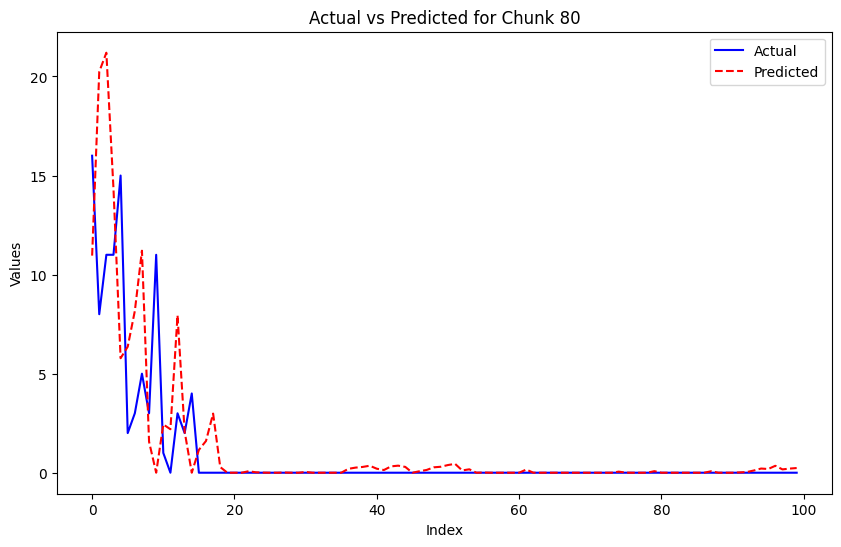

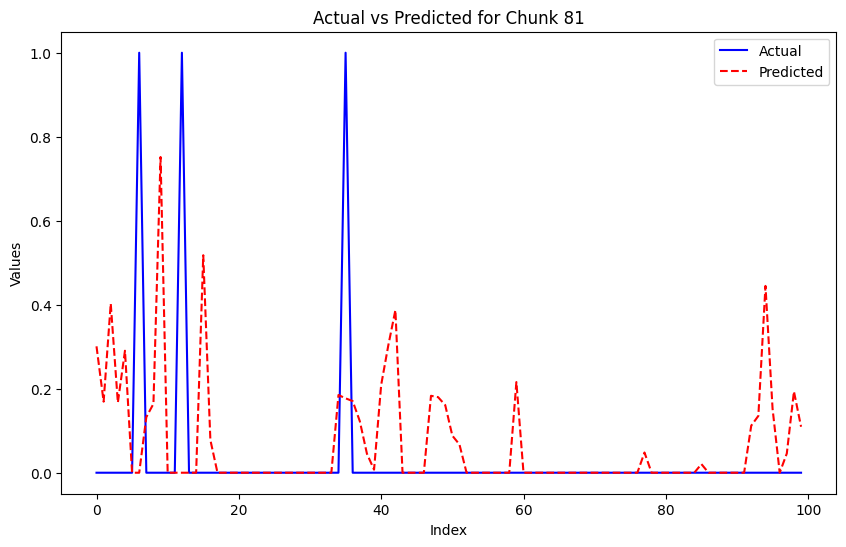

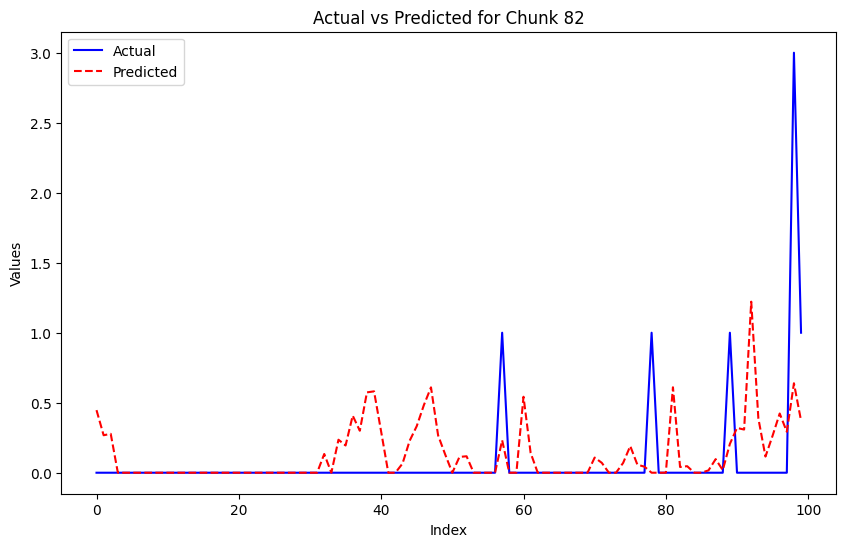

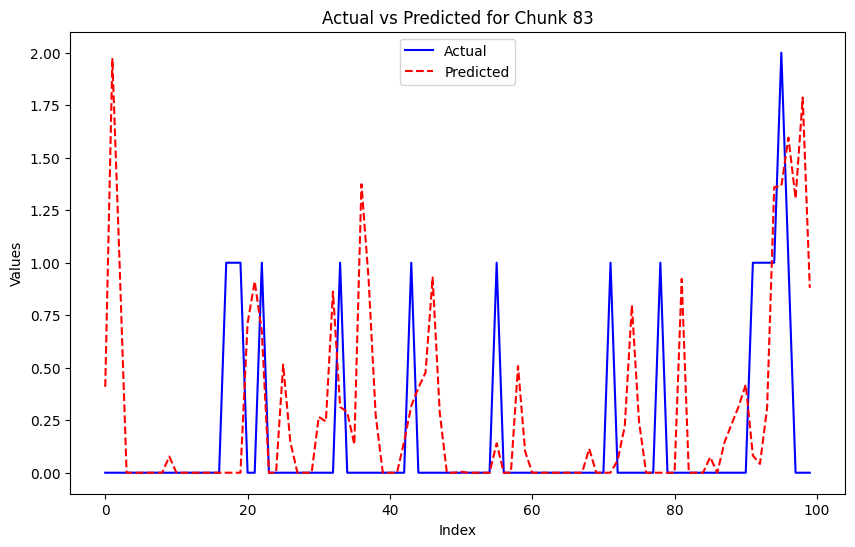

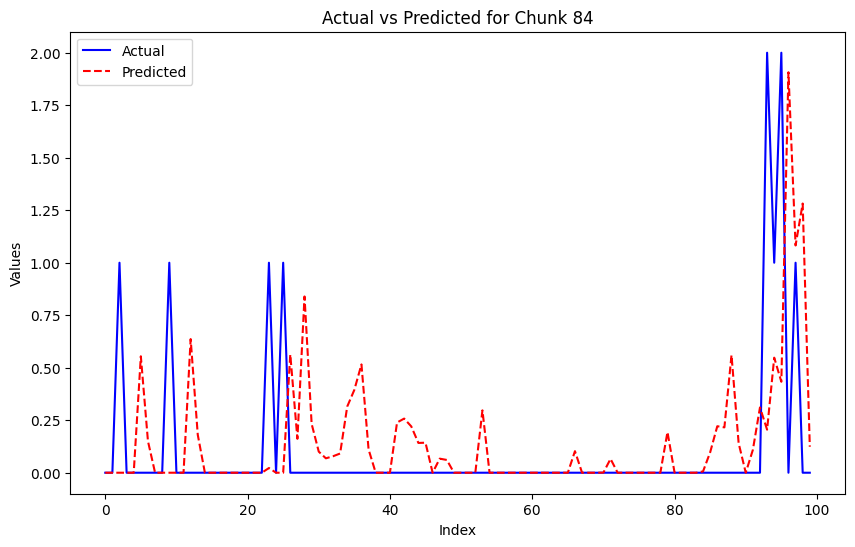

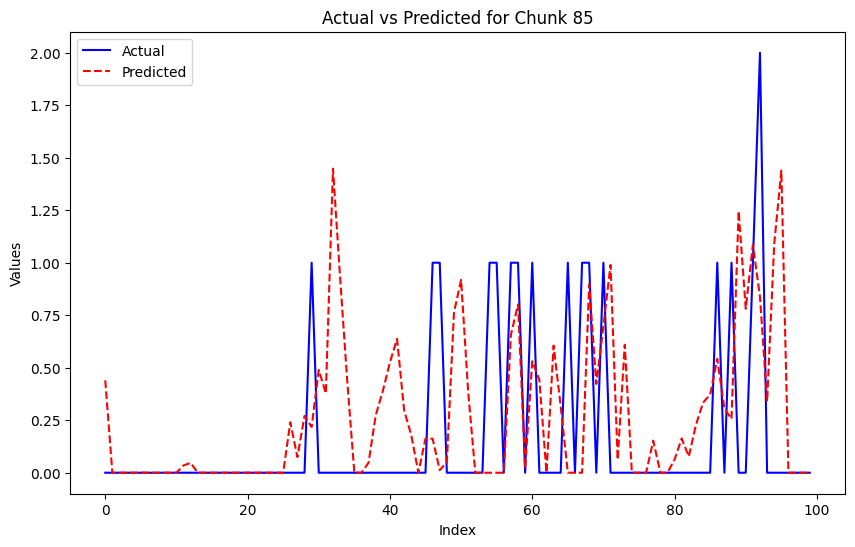

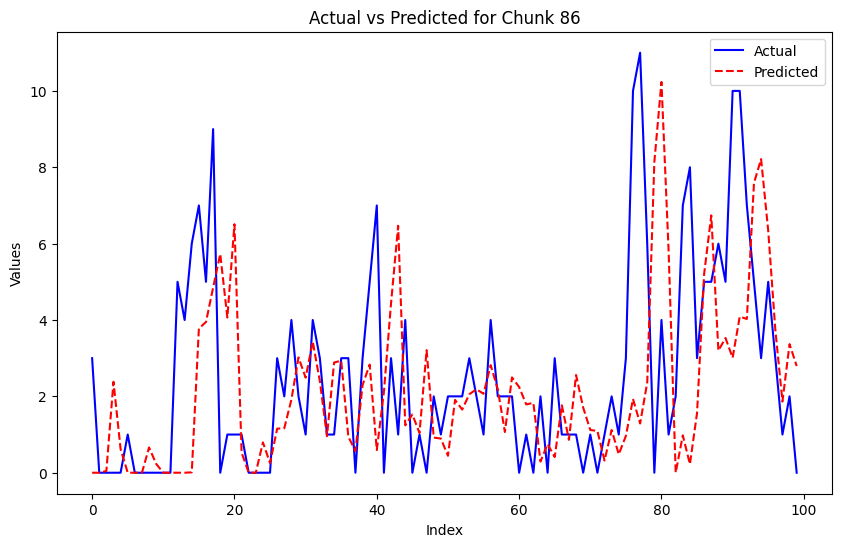

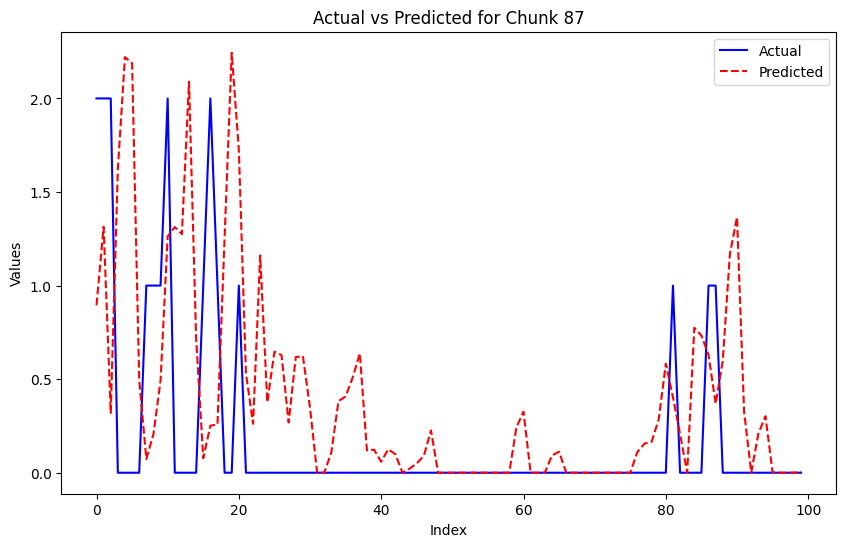

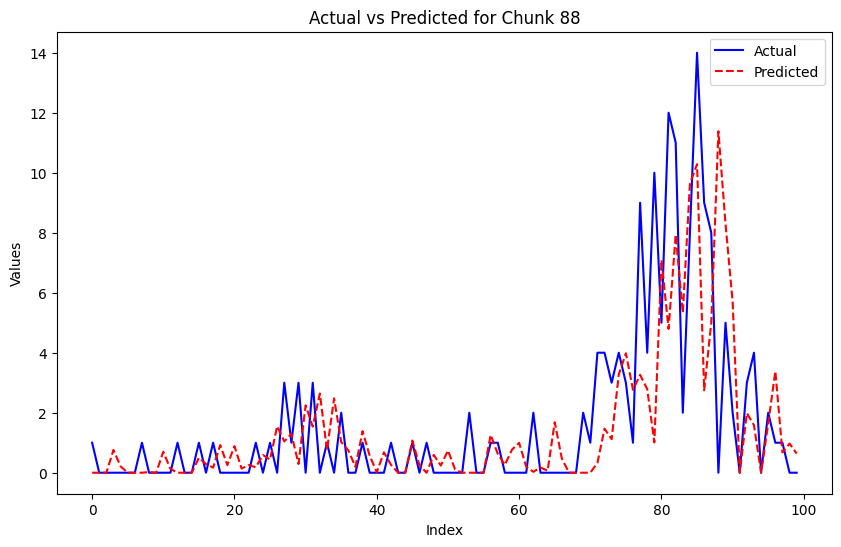

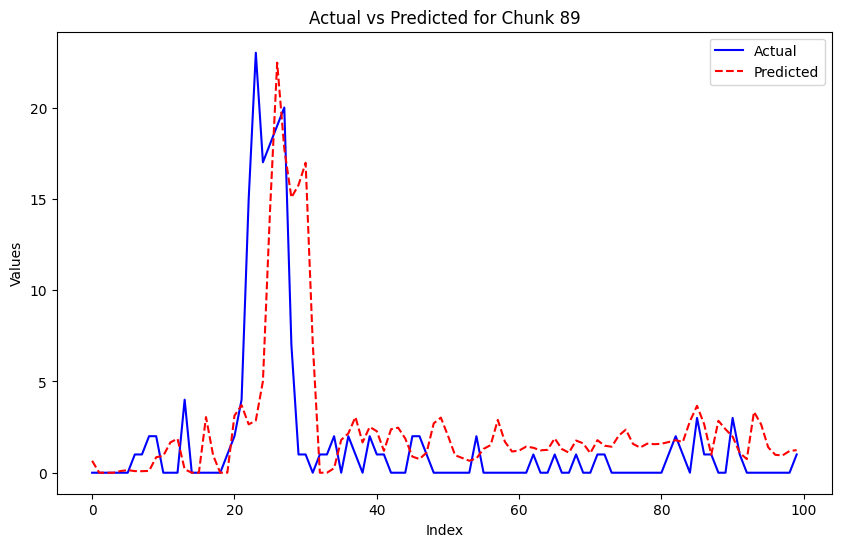

In [11]:
# Make predictions on the test data
predictions = model.predict([X_test_lstm, X_test_geocode])

# Rescale actual values back to the original scale
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Rescale the predicted values back to the original scale
test_predictions_rescaled = target_scaler.inverse_transform(predictions)
test_predictions_rescaled = np.clip(test_predictions_rescaled, 0, None)


import matplotlib.pyplot as plt

# Number of cases per plot (as you specified: 100)
chunk_size = 100
num_chunks = len(test_predictions_rescaled) // chunk_size

# Loop through each chunk and plot the actual vs predicted values
for i in range(num_chunks):
    # Get the start and end indices for the current chunk
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size
    
    # Get the actual and predicted values for the current chunk
    actual_chunk = y_test_rescaled[start_idx:end_idx]
    predicted_chunk = test_predictions_rescaled[start_idx:end_idx]
    
    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(actual_chunk, label='Actual', color='blue')
    plt.plot(predicted_chunk, label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted for Chunk {i+1}')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
